# Прогноз оттока клиентов

Оператор связи "ТелеДом" хочет бороться с оттоком клиентов.  

Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах.

**Описание услуг**  

Оператор предоставляет два основных типа услуг:  
- Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.  
- Интернет. Подключение может быть двух типов: через телефонную линию (DSL) или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:  
- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecuurity);  
- Выделенная линия технической поддержки (TechSupport);  
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);  
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).  

Клиенты могут платить за услуги каждый месяц или заключить договор на 1-2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.  

**Цель проекта:** повысить лояльность действующих клиентов, планирующих расторгнуть договор с компанией, путём предложения специальных условий, промокодов и других акций.

**Задача проекта:** построить модель, которая будет предсказывать, расторгнет ли абонент договор; целевая метрика `ROC-AUC` значением не менее 0.85; кроме того, для лучшей модели рассчитать метрику `Accuracy` для интерпретации результатов обучения модели заказчику.

**План работы:**

1) загрузить данные и выполнить их разведочный анализ;
2) объединить данные из отдельных файлов;
3) выполнить исследовательский анализ и предобработку данных;
4) подготовить данные к обучению моделей;
5) обучить несколько моделей, подобрать гиперпараметры моделей;
6) выбрать лучшую модель;
7) сформулировать вывод и рекомендации заказчику.

**Описание данных**  

Данные состоят из нескольких файлов, полученных из разных источников:  

- `contract_new.csv` - информация о договоре;  
- `personal_new.csv` - персональные данные клиента;  
- `internet_new.csv` - информация об интернет-услугах;  
- `phone_new.csv` - информация об услугах телефонии.

**Файл `contract_new.csv`**  
* `customerID` - идентификатор абонента;  
* `BeginDate` - дата начала действия договора;  
* `EndDate` - дата окончания действия договора;  
* `Type` - тип оплаты: раз в год-два или ежемесячно;  
* `PaperlessBilding` - электронный расчётный лист;  
* `PaymentMethod` - тип платежа;  
* `MonthlyCharges` - расходы за месяц;  
* `TotalCharges` - общие расходы абонента.  

**Файл `personal_new.csv`**
* `customerID` - идентификатор пользователя;
* `gender` - пол;
* `SeniorCitizen` - является ли абонент пенсионером;
* `Partner` - есть ли у абонента супруг или супруга;
* `Dependents` - есть ли у абонента дети.

**Файл `internet_new.csv`**  
* `customerID` - идентификатор пользователя;
* `InternetService` - тип подключения;
* `OnlineSecurity` - блокировка опасных сайтов;
* `OnlineBackup` - облачное хранилище файлов для резервного копирования данных;
* `DeviceProtection` - антивирус;
* `TechSupport` - выделенная линия технической поддержки;
* `StreamingTV` - стриминговое телевидение;
* `StreamingMovies` - каталог фильмов.

**Файл `phone_new.csv`**
* `customerID` - идентификатор пользователя;
* `MultipleLines` - подключение телефона к нескольким линиям одновременно.

Во всех файлах столбец `customerID` содержит код клиента. Информация о договорах актуальна на 1 февраля 2020 года.  

In [1]:
#!pip install -U scikit-learn

In [2]:
# Загрузка библиотек
import pandas as pd
import numpy as np

try:
    import matplotlib.pyplot as plt
except:
    !pip install --upgrade matplotlib==3.8.4
    import matplotlib.pyplot as plt

try:
    import seaborn as sns
except:
    !pip install --upgrade seaborn==0.13
    import seaborn as sns

try:
    import phik
except:
    !pip install phik
    import phik

from patsy import dmatrices
from phik.report import plot_correlation_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import (train_test_split,
                                     RandomizedSearchCV)
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (OneHotEncoder,
                                   OrdinalEncoder,
                                   StandardScaler,
                                   MinMaxScaler)
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import (roc_auc_score,
                             accuracy_score,
                             precision_score,
                             recall_score,
                             roc_curve,
                             confusion_matrix,
                             precision_recall_curve)



import warnings
warnings.filterwarnings("ignore")

In [3]:
# Объявляем константы
RANDOM_STATE = 50824
TEST_SIZE = 0.25

## Загрузка данных

In [4]:
# Формула для оптимизации кода вывода первичной информации
def information(dataset):
    display(dataset.head())
    display()
    display(dataset.info())

In [5]:
# Загрузим первый датасет, сразу сделаем столбец 'customerID' индексами, даты загрузим в нужном формате
try:
    contract = pd.read_csv('/datasets/contract_new.csv',
                               index_col='customerID',
                               parse_dates=['BeginDate'])
except:
    contract = pd.read_csv('https://code.s3.yandex.net/datasets/contract_new.csv',
                               index_col='customerID',
                               parse_dates=['BeginDate'])

# Изучим общую информацию о датасете `contract`
information(contract)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   object        
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 440.2+ KB


None

In [6]:
# Загрузим второй датасет, сразу сделаем столбец 'customerID' индексами
try:
    personal = pd.read_csv('/datasets/personal_new.csv',
                               index_col='customerID')
except:
    personal = pd.read_csv('https://code.s3.yandex.net/datasets/personal_new.csv',
                               index_col='customerID')

# Изучим общую информацию о датасете `personal`
information(personal)

,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB


None

In [7]:
# Загрузим третий датасет, сразу сделаем столбец 'customerID' индексами
try:
    internet = pd.read_csv('/datasets/internet_new.csv',
                               index_col='customerID')
except:
    internet = pd.read_csv('https://code.s3.yandex.net/datasets/internet_new.csv',
                               index_col='customerID')

# Изучим общую информацию о датасете `internet`
information(internet)

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB


None

In [8]:
# Загрузим четвёртый датасет, сразу сделаем столбец 'customerID' индексами
try:
    phone = pd.read_csv('/datasets/phone_new.csv',
                               index_col='customerID')
except:
    phone = pd.read_csv('https://code.s3.yandex.net/datasets/phone_new.csv',
                               index_col='customerID')

# Изучим общую информацию о датасете `phone`
information(phone)

,MultipleLines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB


None

**Выводы по загрузке данных.**  
1. Данные загружены, идентификаторы пользователей переведены в индексы таблиц.
2. В первом датасете формат даты начала действия договора изменён на нужный при загрузке, а столбец даты окончания действия договора требует отдельного анализа.
3. Названия столбцов пробелов не содержат, "верблюжий" стиль допустим, чтобы стиль был единым, нужно изменить только название столбца `'gender'` в таблице `'personal'`.
4. Первичный осмотр данных показал отсутствие пропущенных значений в данных.
5. В первых двух датасетах(`contract` и `personal`) 7043 строки, в третьем (`internet`) - 5517 строк, в четвёртом (`phone`) - 6361 строка. То есть число договоров соответствует числу клиентов, пакет интернет-услуг есть не у всех клиентов, так же как пакет услуг телефонии есть не у всех клиентов.
6. В таблице `contract` неверный тип данных в столбцах `'EndDate'` и `'TotalCharges'`. Тип данных необходимо изменить.

## Разведочный анализ данных и их подготовка к работе

### Обработка названий столбцов, проверка на пропуски и дубликаты

In [9]:
# Приведение названий столбцов к единому формату имен
personal = personal.rename(columns={'gender': 'Gender'})
personal.columns

Index(['Gender', 'SeniorCitizen', 'Partner', 'Dependents'], dtype='object')

In [10]:
# Создаём словарь датафреймов `dfs`
dfs = {
    'contract': contract,
    'personal': personal,
    'internet': internet,
    'phone': phone
}

# Создаём цикл для проверки на наличие пропусков и явных и неявных дубликатов в датафреймах из словаря `dfs`
for name, df in dfs.items():
    print(f'Название датафрейма: {name}\n')
    print(f'Количество пропусков\n{df.isna().sum()}\n')
    print(f'Количество дубликатов {df.duplicated().sum()}\n')
    print('-' * 40)

Название датафрейма: contract

Количество пропусков
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

Количество дубликатов 37

----------------------------------------
Название датафрейма: personal

Количество пропусков
Gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

Количество дубликатов 7027

----------------------------------------
Название датафрейма: internet

Количество пропусков
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

Количество дубликатов 5389

----------------------------------------
Название датафрейма: phone

Количество пропусков
MultipleLines    0
dtype: int64

Количество дубликатов 6359

----------------------------------------


Пропуски в данных отсутствуют, явных дубликатов большое количество.

### Изменение типов данных

In [11]:
# Посчитаем уникальные значения в столбце `EndDate` датафрейма `contract`
contract['EndDate'].value_counts()

No            5942
2020-01-01      39
2019-12-01      38
2018-11-01      35
2019-09-01      32
              ... 
2014-09-01       2
2015-04-01       2
2014-10-01       1
2014-06-01       1
2014-11-01       1
Name: EndDate, Length: 67, dtype: int64

Можно увидеть, что из 7043 договоров 5942 не имеют даты окончания. Наша задача - предсказать отток клиентов. Следовательно, по столбцу `'EndDate'` можно сформировать бинарный целевой признак: `1` - есть отток клиента, `0` - нет оттока клиента. Значение `1` присваиваем, если есть дата окончания договора (клиент разорвал договор), значение `0` - если её нет (клиент остаётся абонентом). Создаём в таблице новый столбец `'Outflow'`.

In [12]:
contract['Outflow'] = contract['EndDate'].apply(lambda x: 0 if x == 'No' else 1)
contract.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Outflow
customerID,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,0
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,0
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,0
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,0
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,0


В самом столбце `'EndDate'` необходимо избавиться от значения `No`, чтобы весь столбец привести к типу `datetime` для дальнейшей работы с датами. Так как рассматриваются данные, актуальные на 1 февраля 2020 года, заменим значения `No` (заглушку) на актуальную дату (дату выгрузки) `2020-02-01` и переведём в нужный формат.

In [13]:
contract['EndDate'] = pd.to_datetime(contract['EndDate'].replace('No', '2020-02-01'))
information(contract)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Outflow
customerID,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0
3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.6,0
9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.5,0


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   object        
 7   Outflow           7043 non-null   int64         
dtypes: datetime64[ns](2), float64(1), int64(1), object(4)
memory usage: 495.2+ KB


None

In [14]:
# Проверим, почему в столбце 'TotalCharges' тип данных `object
contract['TotalCharges'].min()

' '

In [15]:
# Имеются пробелы вместо значений, фактически это пропущенные значения, заменим их на NaN
# после этого изменим тип данных на `float`
contract = contract.replace(' ', np.nan)
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'])
information(contract)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Outflow
customerID,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0
3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,0
9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,0


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7032 non-null   float64       
 7   Outflow           7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(1), object(3)
memory usage: 495.2+ KB


None

**Выводы по разведочному анализу данных.**  
1. Названия столбцов приведены к единому формату.
2. Создан столбец с целевым признаком.
3. Типы данных изменены на корректные.
4. После изменений есть пропущенные значения, есть большое количество явных дубликатов. Необходимо рассмотреть их после объединения данных.
5. Неявных дубликатов не обнаружено.

## Объединение данных

In [16]:
# Объединяем данные из всех четырёх таблиц по индексу, используем метод `join`
# В методе `join` по умолчанию используется `how='left'`, то что нам надо, чтобы не потерять клиентов
data = contract.join([personal, internet, phone])
information(data)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Outflow,Gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,0,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,0,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7032 non-null   float64       
 7   Outflow           7043 non-null   int64         
 8   Gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   5517 non-null   object        
 13  OnlineSecurity    5517 non-null   object        
 14  OnlineBackup  

None

In [17]:
# Проверим датафрейм на пропуски и дубликаты (явные и неявные)
print(f'Количество пропусков\n{data.isna().sum()}\n')
print(f'Количество дубликатов {data.duplicated().sum()}\n')
print('Уникальные значения в категориальных столбцах:')
data_cat = data.select_dtypes(include=['object'])
for column in data_cat.columns:
    print(f'столбец "{column}": {data_cat[column].unique()}')

Количество пропусков
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges          11
Outflow                0
Gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64

Количество дубликатов 4

Уникальные значения в категориальных столбцах:
столбец "Type": ['Month-to-month' 'One year' 'Two year']
столбец "PaperlessBilling": ['Yes' 'No']
столбец "PaymentMethod": ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
столбец "Gender": ['Female' 'Male']
столбец "Partner": ['Yes' 'No']
столбец "Dependents": ['No' 'Yes']
столбец "InternetService": ['DSL' 'Fiber optic' nan]
столбец "OnlineSecurity

In [18]:
# Очистим данные от дубликатов
print('Число строк до очистки:', len(data))
data = data.drop_duplicates()
print('Число строк после очистки:', len(data))

Число строк до очистки: 7043
Число строк после очистки: 7039


Имеется 11 пропусков в столбце `'TotalCharges'`. Попробуем с ними разобраться. Выведем строки датафрейма, где есть пропущенные значения в этом столбце.

In [19]:
data_null = data[data['TotalCharges'].isna()]
data_null

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Outflow,Gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,,
4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,0,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NaN
3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,0,Male,0,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,0,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,0,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,0,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN
7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,0,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,0,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,0,Female,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,0,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No


In [20]:
# Выведем униальные значения в столбцах `BeginDate` у клиентов с пропущенными значениями в столбце `TotalCharges`
data_null['BeginDate'].unique()

array(['2020-02-01T00:00:00.000000000'], dtype='datetime64[ns]')

Дата в столбце `'BeginDate'` у всех клиентов с пропущенными значениями в столбце `'TotalCharges'` - это дата выгрузки датасета. Получается, что клиенты с пропущенными значениями в столбце `'TotalCharges'` - это клиенты, которые только что заключили договор, а месяц только начался, то есть они ещё не успели внести месячный платёж. Пропущенное значение можно заполнить значением из столбца `'MonthlyCharges'` (если мы предположим, что будет внесена месячная оплата) или нулём (если мы не уверены, что оплата вообще будет внесена). Правильнее будет заполнить пропущенные значения нулями, всё-таки на актуальную дату оплаты нет.

In [21]:
data['TotalCharges'] = data['TotalCharges'].fillna(0)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7039 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7039 non-null   datetime64[ns]
 1   EndDate           7039 non-null   datetime64[ns]
 2   Type              7039 non-null   object        
 3   PaperlessBilling  7039 non-null   object        
 4   PaymentMethod     7039 non-null   object        
 5   MonthlyCharges    7039 non-null   float64       
 6   TotalCharges      7039 non-null   float64       
 7   Outflow           7039 non-null   int64         
 8   Gender            7039 non-null   object        
 9   SeniorCitizen     7039 non-null   int64         
 10  Partner           7039 non-null   object        
 11  Dependents        7039 non-null   object        
 12  InternetService   5516 non-null   object        
 13  OnlineSecurity    5516 non-null   object        
 14  OnlineBackup  

Что касается пропущенных значений в столбцах с отдельными услугами в пакетах интернета и телефонии, с ними разберёмся отдельно. Если в столбцах с услугами стоит `'nan'`, то пакет услуг отсутствует, если же есть какое-то значение (даже `'No'`), то пакет услуг подключён, просто нет какой-то конкретной услуги. У каждого клиента может быть один пакет услуг или оба. Заменим значение `'nan'` на `'No package'`. Такую замену мы сможем использовать впоследствии для создания новых признаков.

In [22]:
data = data.fillna('No package')
data.isna().sum()

BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Outflow             0
Gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64

Типы данных, которые мы поменялы в предыдущем разделе, остались корректными. Обратим внимание также на тип данных в столбце `'SeniorCitizen'`: тип данных числовой, хотя по сути это бинарный признак `'Yes'` или `'No'`. Чтобы случайно не обработать эти данные как числовые, поменяем тип данных на `object`.

In [23]:
data['SeniorCitizen'] = data['SeniorCitizen'].astype(object)
data.dtypes

BeginDate           datetime64[ns]
EndDate             datetime64[ns]
Type                        object
PaperlessBilling            object
PaymentMethod               object
MonthlyCharges             float64
TotalCharges               float64
Outflow                      int64
Gender                      object
SeniorCitizen               object
Partner                     object
Dependents                  object
InternetService             object
OnlineSecurity              object
OnlineBackup                object
DeviceProtection            object
TechSupport                 object
StreamingTV                 object
StreamingMovies             object
MultipleLines               object
dtype: object

In [24]:
data.shape

(7039, 20)

**Выводы по объединению данных.**  
1. Данные объединили в один датафрейм, убедились, что клиентов при этом не потеряли (число строк не изменилось).
2. Избавились от пропусков и дубликатов.
3. Ошибок и неявных дубликатов не обнаружено.
4. После очистки и обработки осталось 7039 строк и 20 столбцов (из них один с целевым признаком).

## Исследовательский анализ и предобработка данных объединённого датафрейма

### Основные статистические характеристики

In [25]:
# Основные статистические характеристики числовых данных
data.describe(include=float).round(2)

,MonthlyCharges,TotalCharges
count,7039.00,7039.00
mean,64.77,2115.08
std,30.08,2111.80
min,18.25,0.00
25%,35.55,437.50
50%,70.35,1343.35
75%,89.85,3236.69
max,118.75,9221.38


Разброс значений велик, особенно в столбце `'TotalCharges'`, минимальные значения примерно одинаковые, средние, квантили и максимальные значения отличаются очень сильно. Стандартное отклонение в обоих столбцах велико.

In [26]:
# Основные статистические характеристики категориальных данных
data.describe(include=object)

,Type,PaperlessBilling,PaymentMethod,Gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
count,7039,7039,7039,7039,7039,7039,7039,7039,7039,7039,7039,7039,7039,7039,7039
unique,3,2,4,2,2,2,2,3,3,3,3,3,3,3,3
top,Month-to-month,Yes,Electronic check,Male,0,No,No,Fiber optic,No,No,No,No,No,No,No
freq,3873,4170,2365,3552,5897,3639,4930,3095,3498,3088,3095,3473,2810,2785,3388


Уникальных значений от 2 до 4. Представлены наиболее частые значения: чаще всего оплата происходит месяц-в-месяц, по электронному расчётному листу, большинство клиентов одинокие мужчины, использующие волоконно-оптическую линию без дополнительных услуг в интернет-пакете и без многоканальной телефонной линии.

### Анализ целевого признака

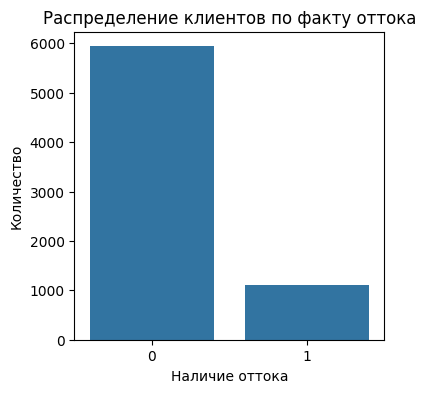

In [27]:
# Построим график распределения целевого признака
plt.subplots(figsize=(4, 4))
ax = sns.countplot(data=data, x='Outflow')
plt.setp(ax, xlabel='Наличие оттока', ylabel='Количество', title='Распределение клиентов по факту оттока')
plt.show()

In [28]:
# Соотношение классов целевого признака
print(round(data.Outflow[data.Outflow == 0].count() / data.Outflow[data.Outflow == 1].count(), 1))

5.4


Дисбаланс классов целевого признака имеет место, число значений `0` в `5,4` раз больше, чем значений `1`. Дисбаланс классов не слишком большой, бороться с ним не будем. Но при дисбалансе классов нужно выбрать целевую метрику для оценки качества модели, нечувствительную к дисбалансу классов. Такой метрикой является `AUC-ROC`, модели будем оценивать по ней. Дополнительно будем рассчитывать метрику `Accuracy`, так как эту метрику легко интерпретировать, и она будет наиболее понятной для заказчика. 

### Исследование входных признаков

In [29]:
# Напишем функцию построения столбчатых диаграмм для категориальных признаков в разбивке по таргету
# функция принимает на вход признак, название графика, подпись оси y
def graphic_cat(characteristic, graphic_name, label_name):
    # формирование размера графика, навания и расстояний между заголовками и между подграфиками
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
    fig.suptitle(graphic_name)
    plt.subplots_adjust(top= 0.85 )
    fig.subplots_adjust(wspace=0.8)
    # первый график - гистограмма в разбивке по таргету
    plt.subplot(1, 2, 1)
    sns.countplot(data=data, y=characteristic, hue='Outflow')
    plt.title('Гистограмма распределения в разбивке по таргету')
    plt.xlabel('Количество')
    plt.ylabel(label_name)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    # второй график - формирование трешхолда для определения показателей с высоким уровнем оттока
    plt.subplot(1, 2, 2)
    sns.barplot(data=data, x='Outflow', y=characteristic)
    plt.title('Порог "отточности" признака')
    plt.xlabel('Уровень оттока')
    plt.ylabel(label_name)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.axvline(np.mean(data['Outflow']), color='r', linestyle='--', label='средний отток')
    plt.legend()
    plt.show()
    # вывод на экран процентного состава значений признака
    print(data.groupby('Outflow')[characteristic].value_counts(normalize=True))

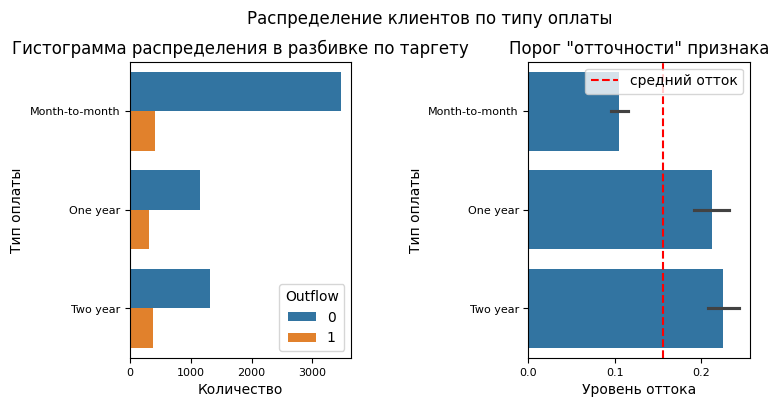

Outflow  Type          
0        Month-to-month    0.583698
         Two year          0.220950
         One year          0.195352
1        Month-to-month    0.369664
         Two year          0.346049
         One year          0.284287
Name: Type, dtype: float64


In [30]:
graphic_cat('Type',
            'Распределение клиентов по типу оплаты',
            'Тип оплаты')

Среди клиентов, разорвавших договор, способы оплаты распределились примерно в равном соотношении, а среди действующих клиентов наиболее популярный тип оплаты - ежемесячный (58,5 %).  
**У клиентов с типом оплаты `'One year'` и `'Two year'` отток выше среднего**, а у клиентов с типом оплаты `'Month-to-month'` - ниже среднего.

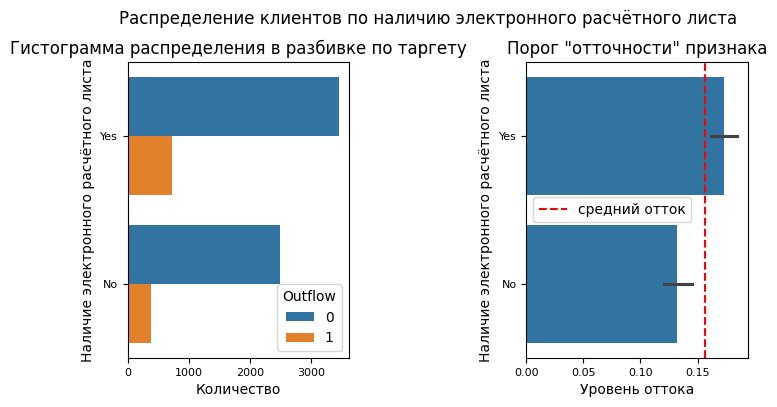

Outflow  PaperlessBilling
0        Yes                 0.580835
         No                  0.419165
1        Yes                 0.654859
         No                  0.345141
Name: PaperlessBilling, dtype: float64


In [31]:
# График распределения клиентов по наличию факта получения электронного расчётного листа
graphic_cat('PaperlessBilling',
            'Распределение клиентов по наличию электронного расчётного листа',
            'Наличие электронного расчётного листа')

Распределение клиентов по наличию электронного расчётного листа мало отличается, 58 % действующих клиентов и 65 % разорвавших договор предпочитают электронный расчётный лист. Предположим, что этот признак мало значим для нашего исследования. Однако можно увидеть, что **у клиентов с электронным расчётным листом уровень оттока выше**.

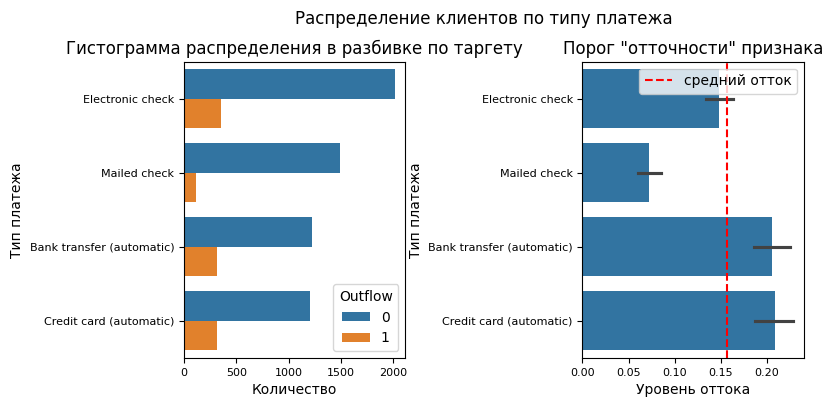

Outflow  PaymentMethod            
0        Electronic check             0.339340
         Mailed check                 0.251263
         Bank transfer (automatic)    0.206635
         Credit card (automatic)      0.202762
1        Electronic check             0.317893
         Bank transfer (automatic)    0.287920
         Credit card (automatic)      0.287920
         Mailed check                 0.106267
Name: PaymentMethod, dtype: float64


In [32]:
# График распределения клиентов по типу платежа
graphic_cat('PaymentMethod',
            'Распределение клиентов по типу платежа',
            'Тип платежа')

Примерно треть клиентов обеих групп предпочитает электронный чек. Чек по почте получает четверть действующих клиентов и только 10 % ушедших. Остальные 41 % действующих клиентов и 57 % ушедших совершали автоплатежи. Можно заметить, что **у клиентов с автоплатежами отток выше среднего**.

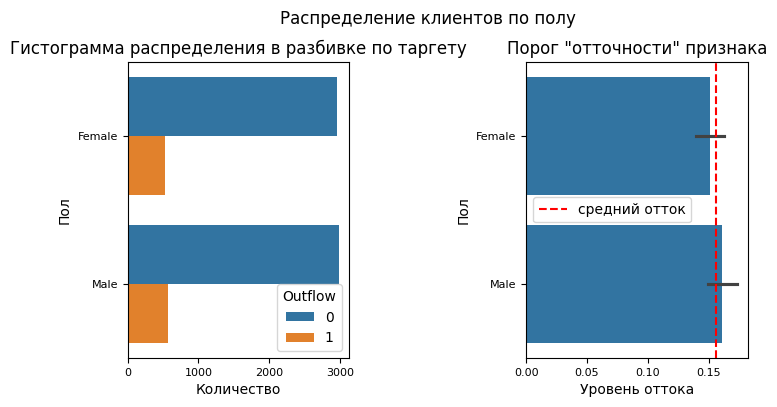

Outflow  Gender
0        Male      0.501684
         Female    0.498316
1        Male      0.520436
         Female    0.479564
Name: Gender, dtype: float64


In [33]:
# График распределения клиентов по полу
graphic_cat('Gender',
            'Распределение клиентов по полу',
            'Пол')

Распределение по полу мало отличается в группах действующих и ушедших клиентов, предполагаем, что признак мало значим для нашего исследования.

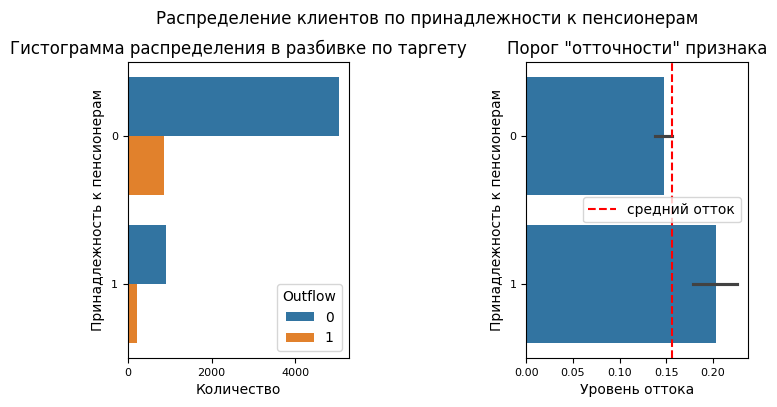

Outflow  SeniorCitizen
0        0                0.846750
         1                0.153250
1        0                0.789282
         1                0.210718
Name: SeniorCitizen, dtype: float64


In [34]:
# График распределения клиентов по принадлежности к пенсионерам
data['SeniorCitizen'] = data['SeniorCitizen'].astype('category')
graphic_cat('SeniorCitizen',
            'Распределение клиентов по принадлежности к пенсионерам',
            'Принадлежность к пенсионерам')

В целом среди клиентов пенсионеров мало. Но среди ушедших клиентов пенсионеров 21 %, а среди оставшихся 15 %. То есть **пенсионеры более склонны к разрыву договора, чем более молодые клиенты**.

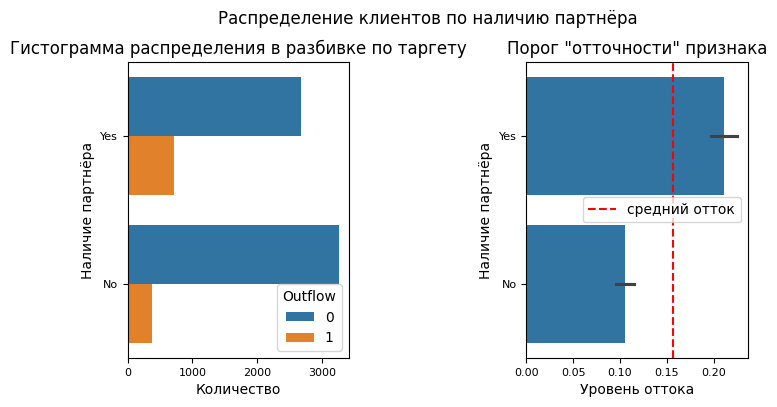

Outflow  Partner
0        No         0.548501
         Yes        0.451499
1        Yes        0.653043
         No         0.346957
Name: Partner, dtype: float64


In [35]:
# График распределения клиентов по наличию супруга(супруги)
graphic_cat('Partner',
            'Распределение клиентов по наличию партнёра',
            'Наличие партнёра')

В данном случае разница заметна: среди действующих клиентов больше не имеющих партнёра людей (55 %), а среди ушедших - больше половины (65,3 %) имеют супруга(супругу). Семейные люди чаще отказываются от услуг компании, чем одинокие. **Уровень оттока у клиентов, имеющих супруга(супругу) выше среднего**.

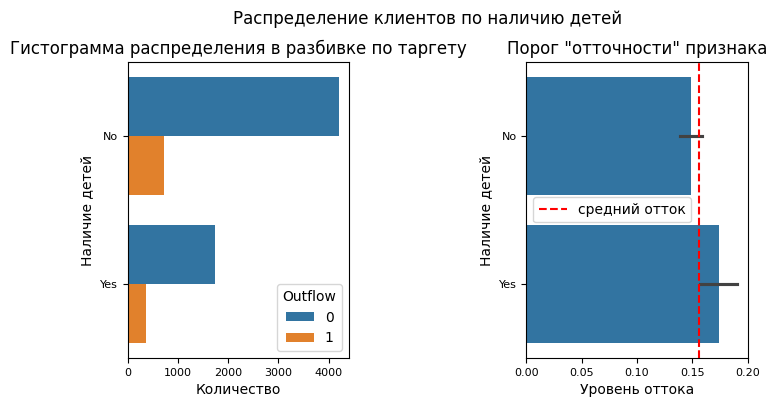

Outflow  Dependents
0        No            0.706804
         Yes           0.293196
1        No            0.665758
         Yes           0.334242
Name: Dependents, dtype: float64


In [36]:
# График распределения клиентов по наличию детей
graphic_cat('Dependents',
            'Распределение клиентов по наличию детей',
            'Наличие детей')

Среди действующих клиентов имеют детей 29 %, а среди ушедших - 33 %. Имеющие детей чаще расторгают договор. **Уровень оттока среди имеющих детей выше среднего**.

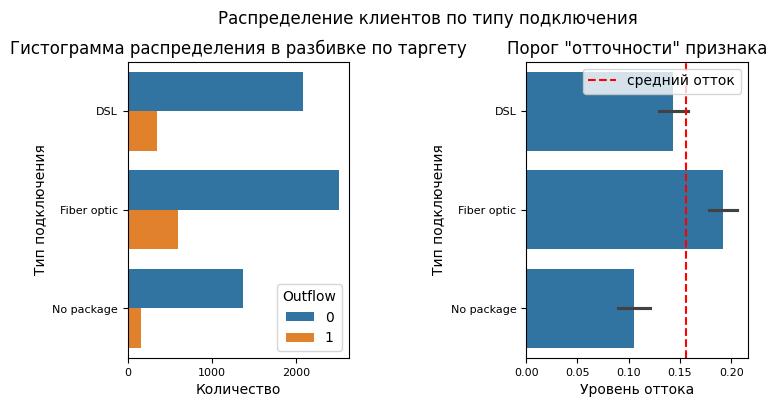

Outflow  InternetService
0        Fiber optic        0.421017
         DSL                0.349444
         No package         0.229539
1        Fiber optic        0.540418
         DSL                0.314260
         No package         0.145322
Name: InternetService, dtype: float64


In [37]:
# График распределения клиентов по типу подключения
graphic_cat('InternetService',
            'Распределение клиентов по типу подключения',
            'Тип подключения')

Больше клиентов обеих групп имеют подключение по волоконно-оптической линии, меньше имеют цифровую абонентскую линию. Разница между рассматриваемыми группами клиентов в том, что среди ушедших 14 % не имели подключения к интернету, а среди оставшихся - 23 %. Похоже, **уходили клиенты, у которых был подключён интернет, а тип подключения - волоконно-оптическая линия**.

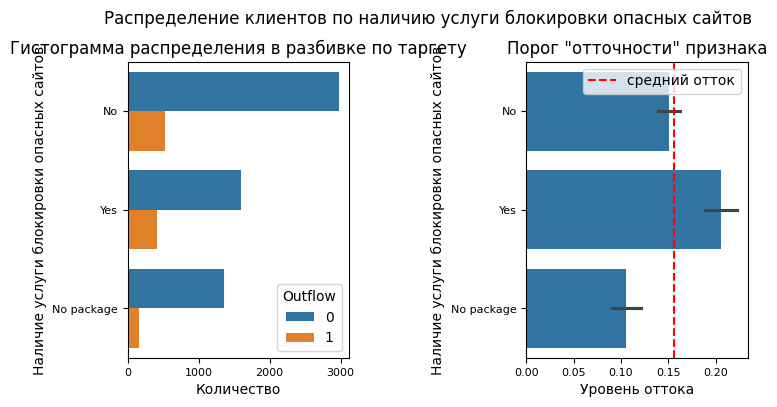

Outflow  OnlineSecurity
0        No                0.500505
         Yes               0.269956
         No package        0.229539
1        No                0.477748
         Yes               0.376930
         No package        0.145322
Name: OnlineSecurity, dtype: float64


In [38]:
# График распределения клиентов по наличию услуги блокировки опасных сайтов
graphic_cat('OnlineSecurity',
            'Распределение клиентов по наличию услуги блокировки опасных сайтов',
            'Наличие услуги блокировки опасных сайтов')

В обеих группах не имели услуги блокировки опасных сайтов больше клиентов, чем имели эту услугу. **Уровень оттока клиентов, пользующихся услугой блокировки опасных сайтов, выше среднего**.

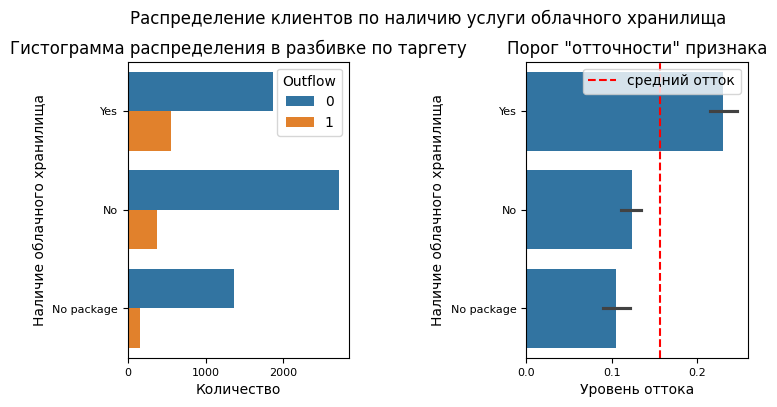

Outflow  OnlineBackup
0        No              0.455877
         Yes             0.314584
         No package      0.229539
1        Yes             0.508629
         No              0.346049
         No package      0.145322
Name: OnlineBackup, dtype: float64


In [39]:
# График распределения клиентов по наличию облачного хранилища
graphic_cat('OnlineBackup',
            'Распределение клиентов по наличию услуги облачного хранилища',
            'Наличие облачного хранилища')

В обеих группах клиентов, не имеющих облачного хранилища файлов, больше, чем имеющих.  **Отток клиентов, имеющих облачное хранилище файлов, выше среднего**.

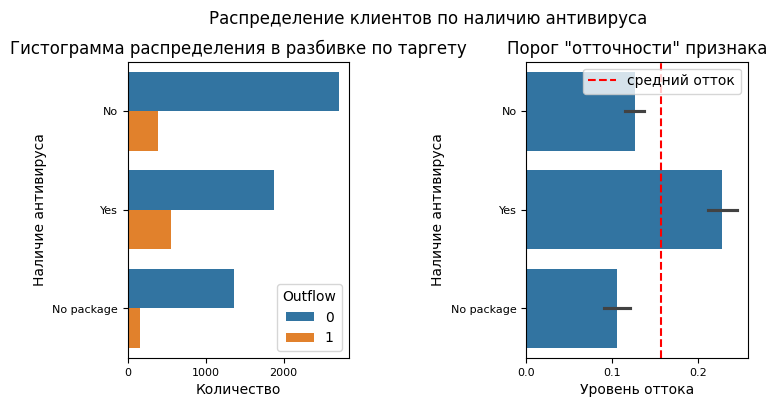

Outflow  DeviceProtection
0        No                  0.455372
         Yes                 0.315089
         No package          0.229539
1        Yes                 0.499546
         No                  0.355132
         No package          0.145322
Name: DeviceProtection, dtype: float64


In [40]:
# График распределения клиентов по наличию антивируса
graphic_cat('DeviceProtection',
            'Распределение клиентов по наличию антивируса',
            'Наличие антивируса')

Вот очень значимое наблюдение: среди ушедших клиентов половина имели антивирус, а среди оставшихся - только 31 %. **Уровень оттока среди имеющих антивирус, выше среднего**.

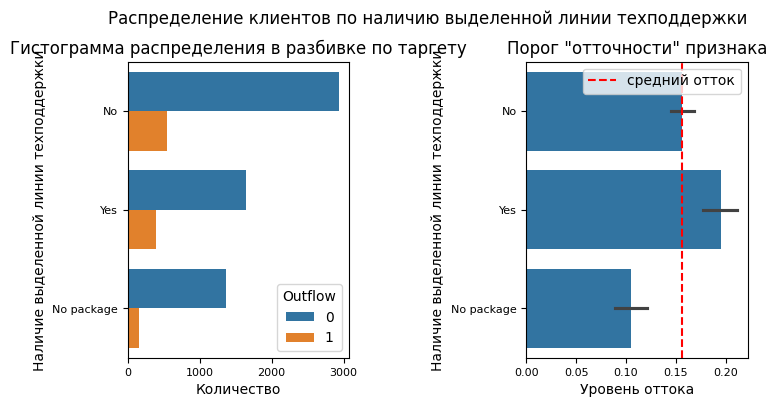

Outflow  TechSupport
0        No             0.493432
         Yes            0.277029
         No package     0.229539
1        No             0.493188
         Yes            0.361490
         No package     0.145322
Name: TechSupport, dtype: float64


In [41]:
# График распределения клиентов по наличию выделенной линии техподдержки
graphic_cat('TechSupport',
            'Распределение клиентов по наличию выделенной линии техподдержки',
            'Наличие выделенной линии техподдержки')

Здесь распределение похожее, две группы клиентов не очень различаются по наличию выделенной линии технической поддержки. Однако **уровень оттока всё же выше среди клиентов, имеющих выделенную линию технической поддержки**.

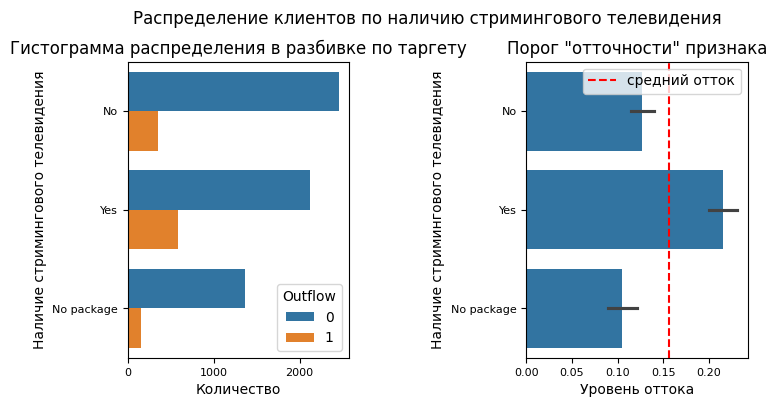

Outflow  StreamingTV
0        No             0.413102
         Yes            0.357359
         No package     0.229539
1        Yes            0.530427
         No             0.324251
         No package     0.145322
Name: StreamingTV, dtype: float64


In [42]:
# График распределения клиентов по наличию стримингового телевидения
graphic_cat('StreamingTV',
            'Распределение клиентов по наличию стримингового телевидения',
            'Наличие стримингового телевидения')

Опять важное наблюдение: среди ушедших клиентов 53 % имели стриминговое телевидение, а среди оставшихся - только 35,7 %. **Уровень оттока выше среди имеющих стриминговое телевидение**.

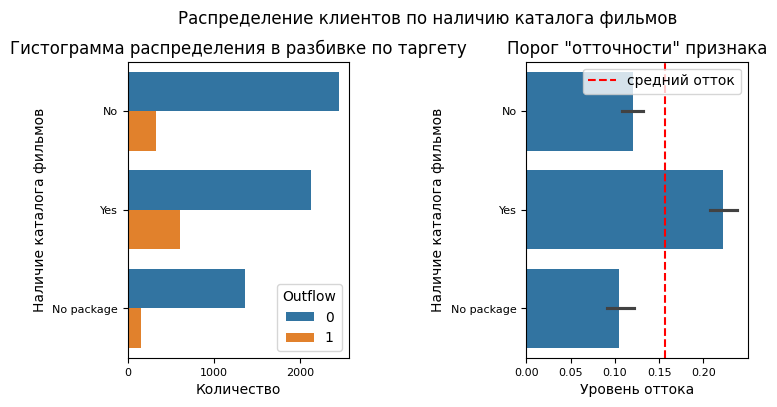

Outflow  StreamingMovies
0        No                 0.412597
         Yes                0.357865
         No package         0.229539
1        Yes                0.550409
         No                 0.304269
         No package         0.145322
Name: StreamingMovies, dtype: float64


In [43]:
# График распределения клиентов по наличию каталога фильмов
graphic_cat('StreamingMovies',
            'Распределение клиентов по наличию каталога фильмов',
            'Наличие каталога фильмов')

55 % ушедших клиентов имели каталог фильмов, а из оставшихся - только 35,8 % имели его. **Уровень оттока выше среди клиентов, имеющих каталог фильмов**.

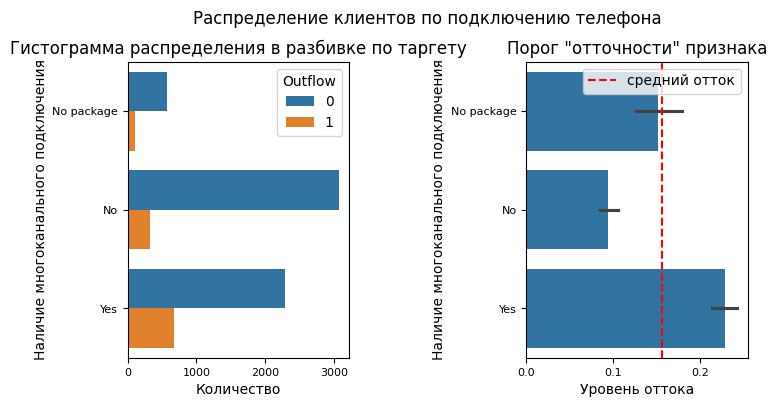

Outflow  MultipleLines
0        No               0.516672
         Yes              0.385820
         No package       0.097508
1        Yes              0.615804
         No               0.290645
         No package       0.093551
Name: MultipleLines, dtype: float64


In [44]:
# График распределения клиентов по подключению телефона
graphic_cat('MultipleLines',
            'Распределение клиентов по подключению телефона',
            'Наличие многоканального подключения')

Не имели подключения к телефонной связи менее 1 % клиентов обеих групп. Среди ушедших 61,6 % имели подключение к нескольким линиям одновременно, а среди оставшихся - 51,7 %. **Уровень оттока выше среднего у клиентов, имеющих подключение к услуге**.

In [45]:
# Напишем функцию построения графиков для количественных признаков
def graphics_num(characteristic, feature_title, binwidth):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
    fig.suptitle(feature_title)
    sns.histplot(data=data,
                 x=characteristic, 
                 hue='Outflow', 
                 binwidth=binwidth, 
                 stat='density', 
                 common_norm=False, 
                 ax=axes[0])
    axes[0].set_title('Гистограмма распределения')
    sns.violinplot(data=data,  
                   y=characteristic, 
                   hue='Outflow', 
                   ax=axes[1])
    axes[1].set_title('Разброс значений признаков')
    plt.show()

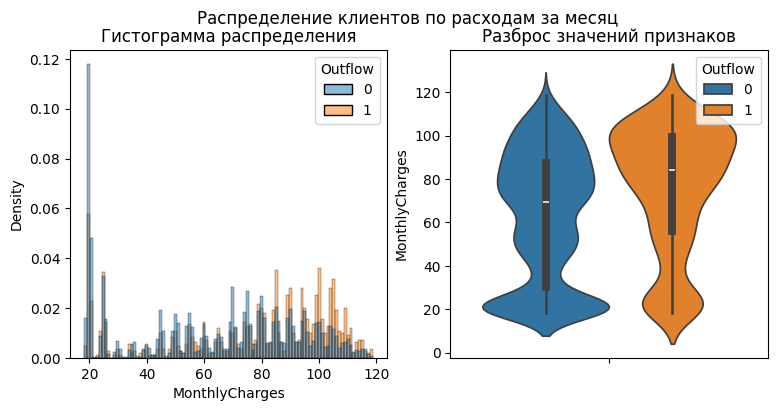

In [46]:
# Графики распределения клиентов по расходам за месяц
graphics_num('MonthlyCharges',
             'Распределение клиентов по расходам за месяц',
             1)

Некоторая дискретность на гистограмме наблюдается, по-видимому, в связи с тарифными планами и определёнными наборами услуг абонентов.  
Имеется пик в самых низких значения расходов за месяц (около 20), но клиентов с такими расходами среди действующих клиентов вдвое больше, чем среди ушедших. Второй пик наблюдается для действующих клиентов около 70, а для ушедших клиентов - около 100. Медианное значение месячных расходов также различается: для действующих клиентов оно около 70, а для ушедших - более 80.  
На графике видно, что клиент чаще всего уходит при больших ежемесячных затратах. Большинство клиентов, которые не разорвали договор с компанией, платят 20 условных денежных единиц. **При размере платежа 90-100 единиц шанс расторжения договора сильно повышается**.

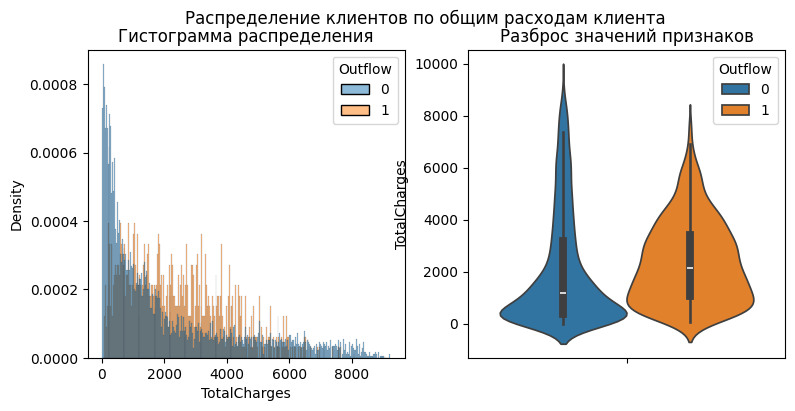

In [47]:
# Графики распределения клиентов по общим расходам абонента
graphics_num('TotalCharges',
             'Распределение клиентов по общим расходам клиента',
             30)

Среди ушедших клиентов достаточно большое количество и с низкими общими расходами, и со средним размером общих расходов, и даже чуть выше среднего. Зато почти нет клиентов с самыми большими общими расходами.
Среди действующих клиентов подавляющее большинство имеет низкие общие расходы, но дальше почти равномерно распределённое количество клиентов с общими расходами чуть ниже средних, средними, высокими и очень высокими.  
У действующих клиентов медианное значение общих расходов меньше, чем у ушедших клиентов. И разброс значений заметно больше, имеется много очень больших общих расходов, похоже, что действующие клиенты дольше являются клиентами компании, чем ушедшие. У ушедших клиентов самые низкие суммы общих расходов встречаются в 2 раза реже, зато значительно чаще встречаются суммарные расходы средних размеров.  
Похоже, **ушедшие клиенты имели расходы больше, но клиентами оставались более короткий срок, чем действующие клиенты**.

### Создание новых входных признаков

In [48]:
# Создадим признак `'Duration'` - длительность договора клиента
data['Duration'] = (data['EndDate'] - data['BeginDate']).dt.days

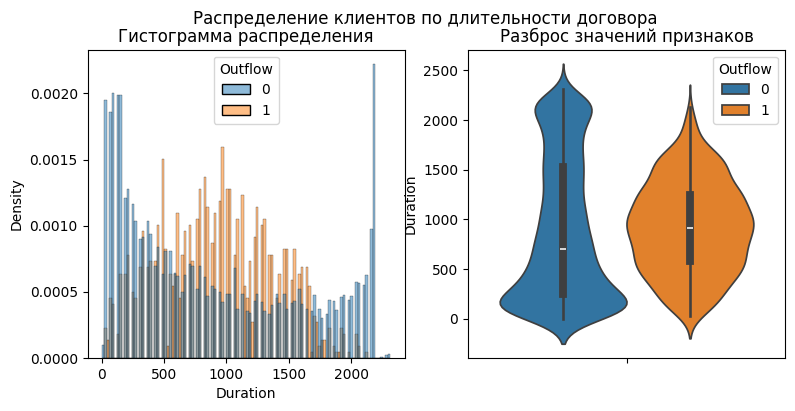

In [49]:
# График распределения клиентов по длительности договора
graphics_num('Duration',
             'Распределение клиентов по длительности договора',
             20)

Распределение клиентов, разорвавших договор, по длительности договора нормальное, его медианное значение около 950 дней, то есть **длительность договора ушедших клиентов 2,5 года**. Распределение действующих клиентов по длительности договора имеет большой разброс, очень много клиентов недавних, имеющих маленькую длительность договора. Другой пик находится в самых больших значениях, около 6 лет. То есть много действующих клиентов с большим стажем. Медиана находится в значении около 700 дней, то есть около 2 лет.

In [50]:
# Подсчитаем количество дней, которые остались до очередной оплаты услуг
# функция принимает на вход строку
def days_before_pay(row):
    # если тип оплаты ежемесячный, берём остаток от деления продолжительности контракта на 30
    if row['Type'] == 'Month-to-month':
        return row['Duration'] % 30
    # если оплата за год, берём остаток от деления продолжительности на 365
    elif row['Type'] == 'One year':
        return row['Duration'] % 365
    # в остальных случаях (оплата за два года), берём остаток от деления на 730
    else:
        return row['Duration'] % 730

data['Days_bp'] = data.apply(days_before_pay, axis=1)
data.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Outflow,Gender,SeniorCitizen,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Duration,Days_bp
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,Female,0,...,DSL,No,Yes,No,No,No,No,No package,31,1
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0,Male,0,...,DSL,Yes,No,Yes,No,No,No,No,1036,306
3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0,Male,0,...,DSL,Yes,Yes,No,No,No,No,No,123,3
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,0,Male,0,...,DSL,Yes,No,Yes,Yes,No,No,No package,1371,276
9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,0,Female,0,...,Fiber optic,No,No,No,No,No,No,No,153,3


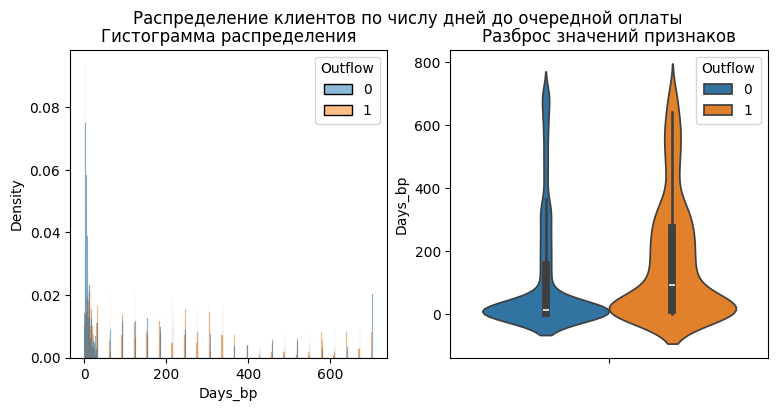

In [51]:
# График распределения клиентов по числу дней до очередной оплаты
graphics_num('Days_bp',
             'Распределение клиентов по числу дней до очередной оплаты',
             1)

**Чаще всего клиенты разрывают договор за считанные дни до его окончания**. Но бывает и так, что до следующей оплаты ещё много времени, а клиент всё равно уходит.

Рассмотрим услуги интернета и услуги телефонии. Создадим признаки `'InternetPackage'` и `'PhonePackage'`, то есть наличие пакета услуг интернета и телефона.

In [52]:
data['InternetPackage'] = data['InternetService'].apply(lambda x: 'No' if x == 'No package' else 'Yes')
data['PhonePackage'] = data['MultipleLines'].apply(lambda x: 'No' if x == 'No package' else 'Yes')

In [53]:
# Создадим признак `'NumServices' с числом дополнительных услуг у клиента
# Список столбцов с услугами
columns_services = [
    'OnlineSecurity',
    'OnlineBackup',
    'DeviceProtection',
    'TechSupport',
    'StreamingTV',
    'StreamingMovies',
    'MultipleLines'
]

data['NumServices'] = data[data[columns_services] == 'Yes'].count(axis=1)
data.dtypes

BeginDate           datetime64[ns]
EndDate             datetime64[ns]
Type                        object
PaperlessBilling            object
PaymentMethod               object
MonthlyCharges             float64
TotalCharges               float64
Outflow                      int64
Gender                      object
SeniorCitizen             category
Partner                     object
Dependents                  object
InternetService             object
OnlineSecurity              object
OnlineBackup                object
DeviceProtection            object
TechSupport                 object
StreamingTV                 object
StreamingMovies             object
MultipleLines               object
Duration                     int64
Days_bp                      int64
InternetPackage             object
PhonePackage                object
NumServices                  int64
dtype: object

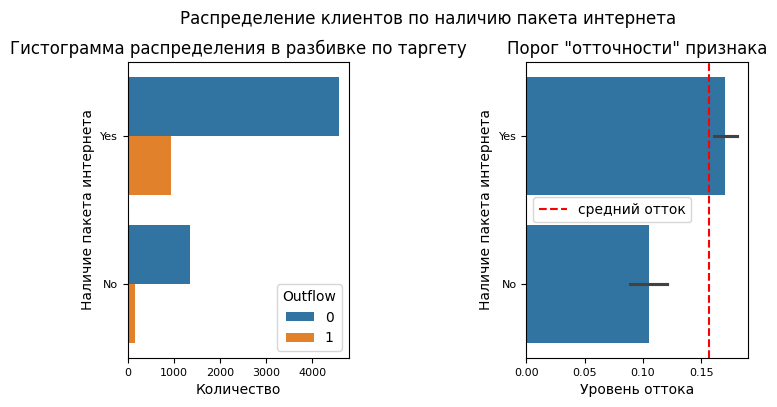

Outflow  InternetPackage
0        Yes                0.770461
         No                 0.229539
1        Yes                0.854678
         No                 0.145322
Name: InternetPackage, dtype: float64


In [54]:
# График распределения клиентов по наличию пакета интернета
graphic_cat('InternetPackage',
            'Распределение клиентов по наличию пакета интернета',
            'Наличие пакета интернета')

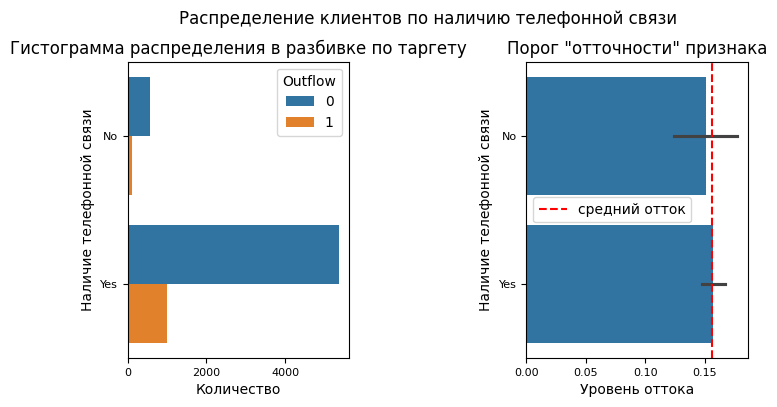

Outflow  PhonePackage
0        Yes             0.902492
         No              0.097508
1        Yes             0.906449
         No              0.093551
Name: PhonePackage, dtype: float64


In [55]:
# График распределения клиентов по наличию телефонной связи
graphic_cat('PhonePackage',
            'Распределение клиентов по наличию телефонной связи',
            'Наличие телефонной связи')

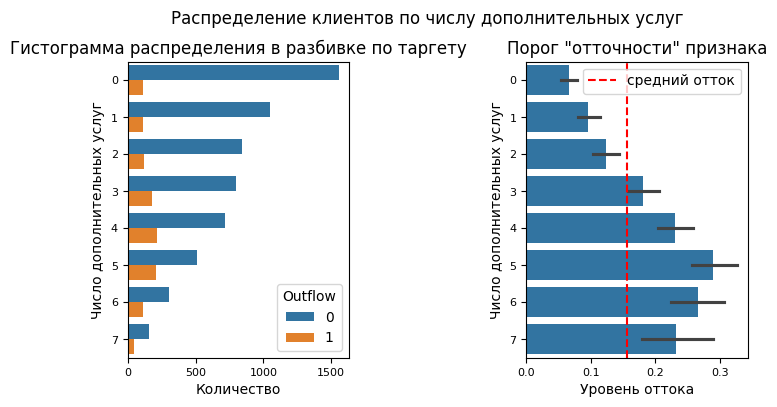

Outflow  NumServices
0        0              0.261704
         1              0.176154
         2              0.141293
         3              0.134894
         4              0.120916
         5              0.086393
         6              0.051869
         7              0.026777
1        4              0.195277
         5              0.189827
         3              0.160763
         2              0.107175
         6              0.101726
         0              0.100817
         1              0.100817
         7              0.043597
Name: NumServices, dtype: float64


In [56]:
# График распределения клиентов по числу дополнительных услуг
data['NumServices'] = data['NumServices'].astype('category')
graphic_cat('NumServices',
            'Распределение клиентов по числу дополнительных услуг',
            'Число дополнительных услуг')

In [57]:
# Вернём признаку `NumServises` целочисленный тип данных
data['NumServices'] = data['NumServices'].astype('int64')
data.dtypes

BeginDate           datetime64[ns]
EndDate             datetime64[ns]
Type                        object
PaperlessBilling            object
PaymentMethod               object
MonthlyCharges             float64
TotalCharges               float64
Outflow                      int64
Gender                      object
SeniorCitizen             category
Partner                     object
Dependents                  object
InternetService             object
OnlineSecurity              object
OnlineBackup                object
DeviceProtection            object
TechSupport                 object
StreamingTV                 object
StreamingMovies             object
MultipleLines               object
Duration                     int64
Days_bp                      int64
InternetPackage             object
PhonePackage                object
NumServices                  int64
dtype: object

Пакет интернет-услуг имеют 77 % действующих клиентов и 85,5 % ушедших. Более 99 % клиентов обеих групп имеют подключение к телефонной связи от данного оператора. То есть признак наличия услуг интернета имеет значение, а признак наличия телефонной связи неинформативен.  
Среди действующих клиентов больше всего клиентов не имеют дополнительных услуг, только базовое подключение к интернету или телефону. А среди ушедших клиентов больше всего клиентов имели от 3 до 5 дополнительных услуг. В целом **у клиентов, имеющих от 3 до 7 дополнительных услуг, уровень оттока выше среднего**.

In [58]:
# После создания новых признаков удалим признаки, из которых они созданы
data_best = data.drop(columns_services, axis=1).drop(['BeginDate', 'EndDate', 'InternetService'], axis=1)
data_best.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Outflow,Gender,SeniorCitizen,Partner,Dependents,Duration,Days_bp,InternetPackage,PhonePackage,NumServices
customerID,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,0,Female,0,Yes,No,31,1,Yes,No,1
5575-GNVDE,One year,No,Mailed check,56.95,2071.84,0,Male,0,No,No,1036,306,Yes,Yes,2
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,0,Male,0,No,No,123,3,Yes,Yes,2
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,0,Male,0,No,No,1371,276,Yes,No,3
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,0,Female,0,No,No,153,3,Yes,Yes,0


In [59]:
# Составим сводную таблицу, где по столбцам будет признак оттока, на строках - признаки,
# а на пересечении - меры центральной тенденции: среднее или медиана для непрерывных и мода для категориальных
data_pivot = data_best.pivot_table(
    # разделяем по признаку оттока
    index='Outflow',
    # значения - признаки
    values=[
        'Type',
        'PaperlessBilling',
        'PaymentMethod',
        'MonthlyCharges',
        'TotalCharges',
        'Gender',
        'SeniorCitizen',
        'Partner',
        'Dependents',
        'Duration',
        'Days_bp',
        'InternetPackage',
        'PhonePackage',
        'NumServices'
    ],
    # применяемые функции к столбцам
    aggfunc={
        'Type': lambda x: x.value_counts().index[0],
        'PaperlessBilling': lambda x: x.value_counts().index[0],
        'PaymentMethod': lambda x: x.value_counts().index[0],
        'MonthlyCharges': 'mean',
        'TotalCharges': 'median',
        'Gender': lambda x: x.value_counts().index[0],
        'SeniorCitizen': lambda x: x.value_counts().index[0],
        'Partner': lambda x: x.value_counts().index[0],
        'Dependents': lambda x: x.value_counts().index[0],
        'Duration': 'median',
        'Days_bp': 'median',
        'InternetPackage': lambda x: x.value_counts().index[0],
        'PhonePackage': lambda x: x.value_counts().index[0],
        'NumServices': lambda x: x.value_counts().index[0]
    }
# транспонируем таблицу
).T
# переименуем столбцы
data_pivot.columns = ['Не отток', 'Отток']
# выводим таблицу на экран
data_pivot

,Не отток,Отток
Days_bp,11,93
Dependents,No,No
Duration,702,915
Gender,Male,Male
InternetPackage,Yes,Yes
MonthlyCharges,62.775514,75.546004
NumServices,0,4
PaperlessBilling,Yes,Yes
Partner,No,Yes
PaymentMethod,Electronic check,Electronic check


In [60]:
# Добавим столбец `Относительное изменение` для числовых столбцов
data_pivot['Относительное изменение'] = data_pivot['Отток'].apply(lambda x: x if type(x) == float else None) / data_pivot['Не отток'] - 1
data_pivot

,Не отток,Отток,Относительное изменение
Days_bp,11,93,NaN
Dependents,No,No,NaN
Duration,702,915,NaN
Gender,Male,Male,NaN
InternetPackage,Yes,Yes,NaN
MonthlyCharges,62.775514,75.546004,0.203431
NumServices,0,4,NaN
PaperlessBilling,Yes,Yes,NaN
Partner,No,Yes,NaN
PaymentMethod,Electronic check,Electronic check,NaN


**Портрет типичного пользователя, который покидает компанию:** мужчина любого возраста, кроме пенсионного, имеющий супругу, но не имеющий детей, пользующийся и интернетом и телефонной связью, подключивший 4 дополнительные услуги, оплачивающий услуги ежемесячно и получающий электронный счёт и электронный чек, являющийся абонентом компании на 30 % дольше, чем остающийся пользователь, имеющий месячный платеж на 20 % выше и общие расходы за период действия договора почти на 80 % больше действующих абонентов, которому осталось до очередного платежа ещё 3 месяца.

### Анализ корреляции признаков

In [61]:
# Построим матрицу корреляции `phik`
# Создадим список с наименованиями непрерывных признаков
interval_cols = ['MonthlyCharges', 'TotalCharges', 'Duration', 'Days_bp']

# Cчитаем корреляции
phik_overview = data_best.phik_matrix(interval_cols=interval_cols)
print(phik_overview.shape)

(15, 15)


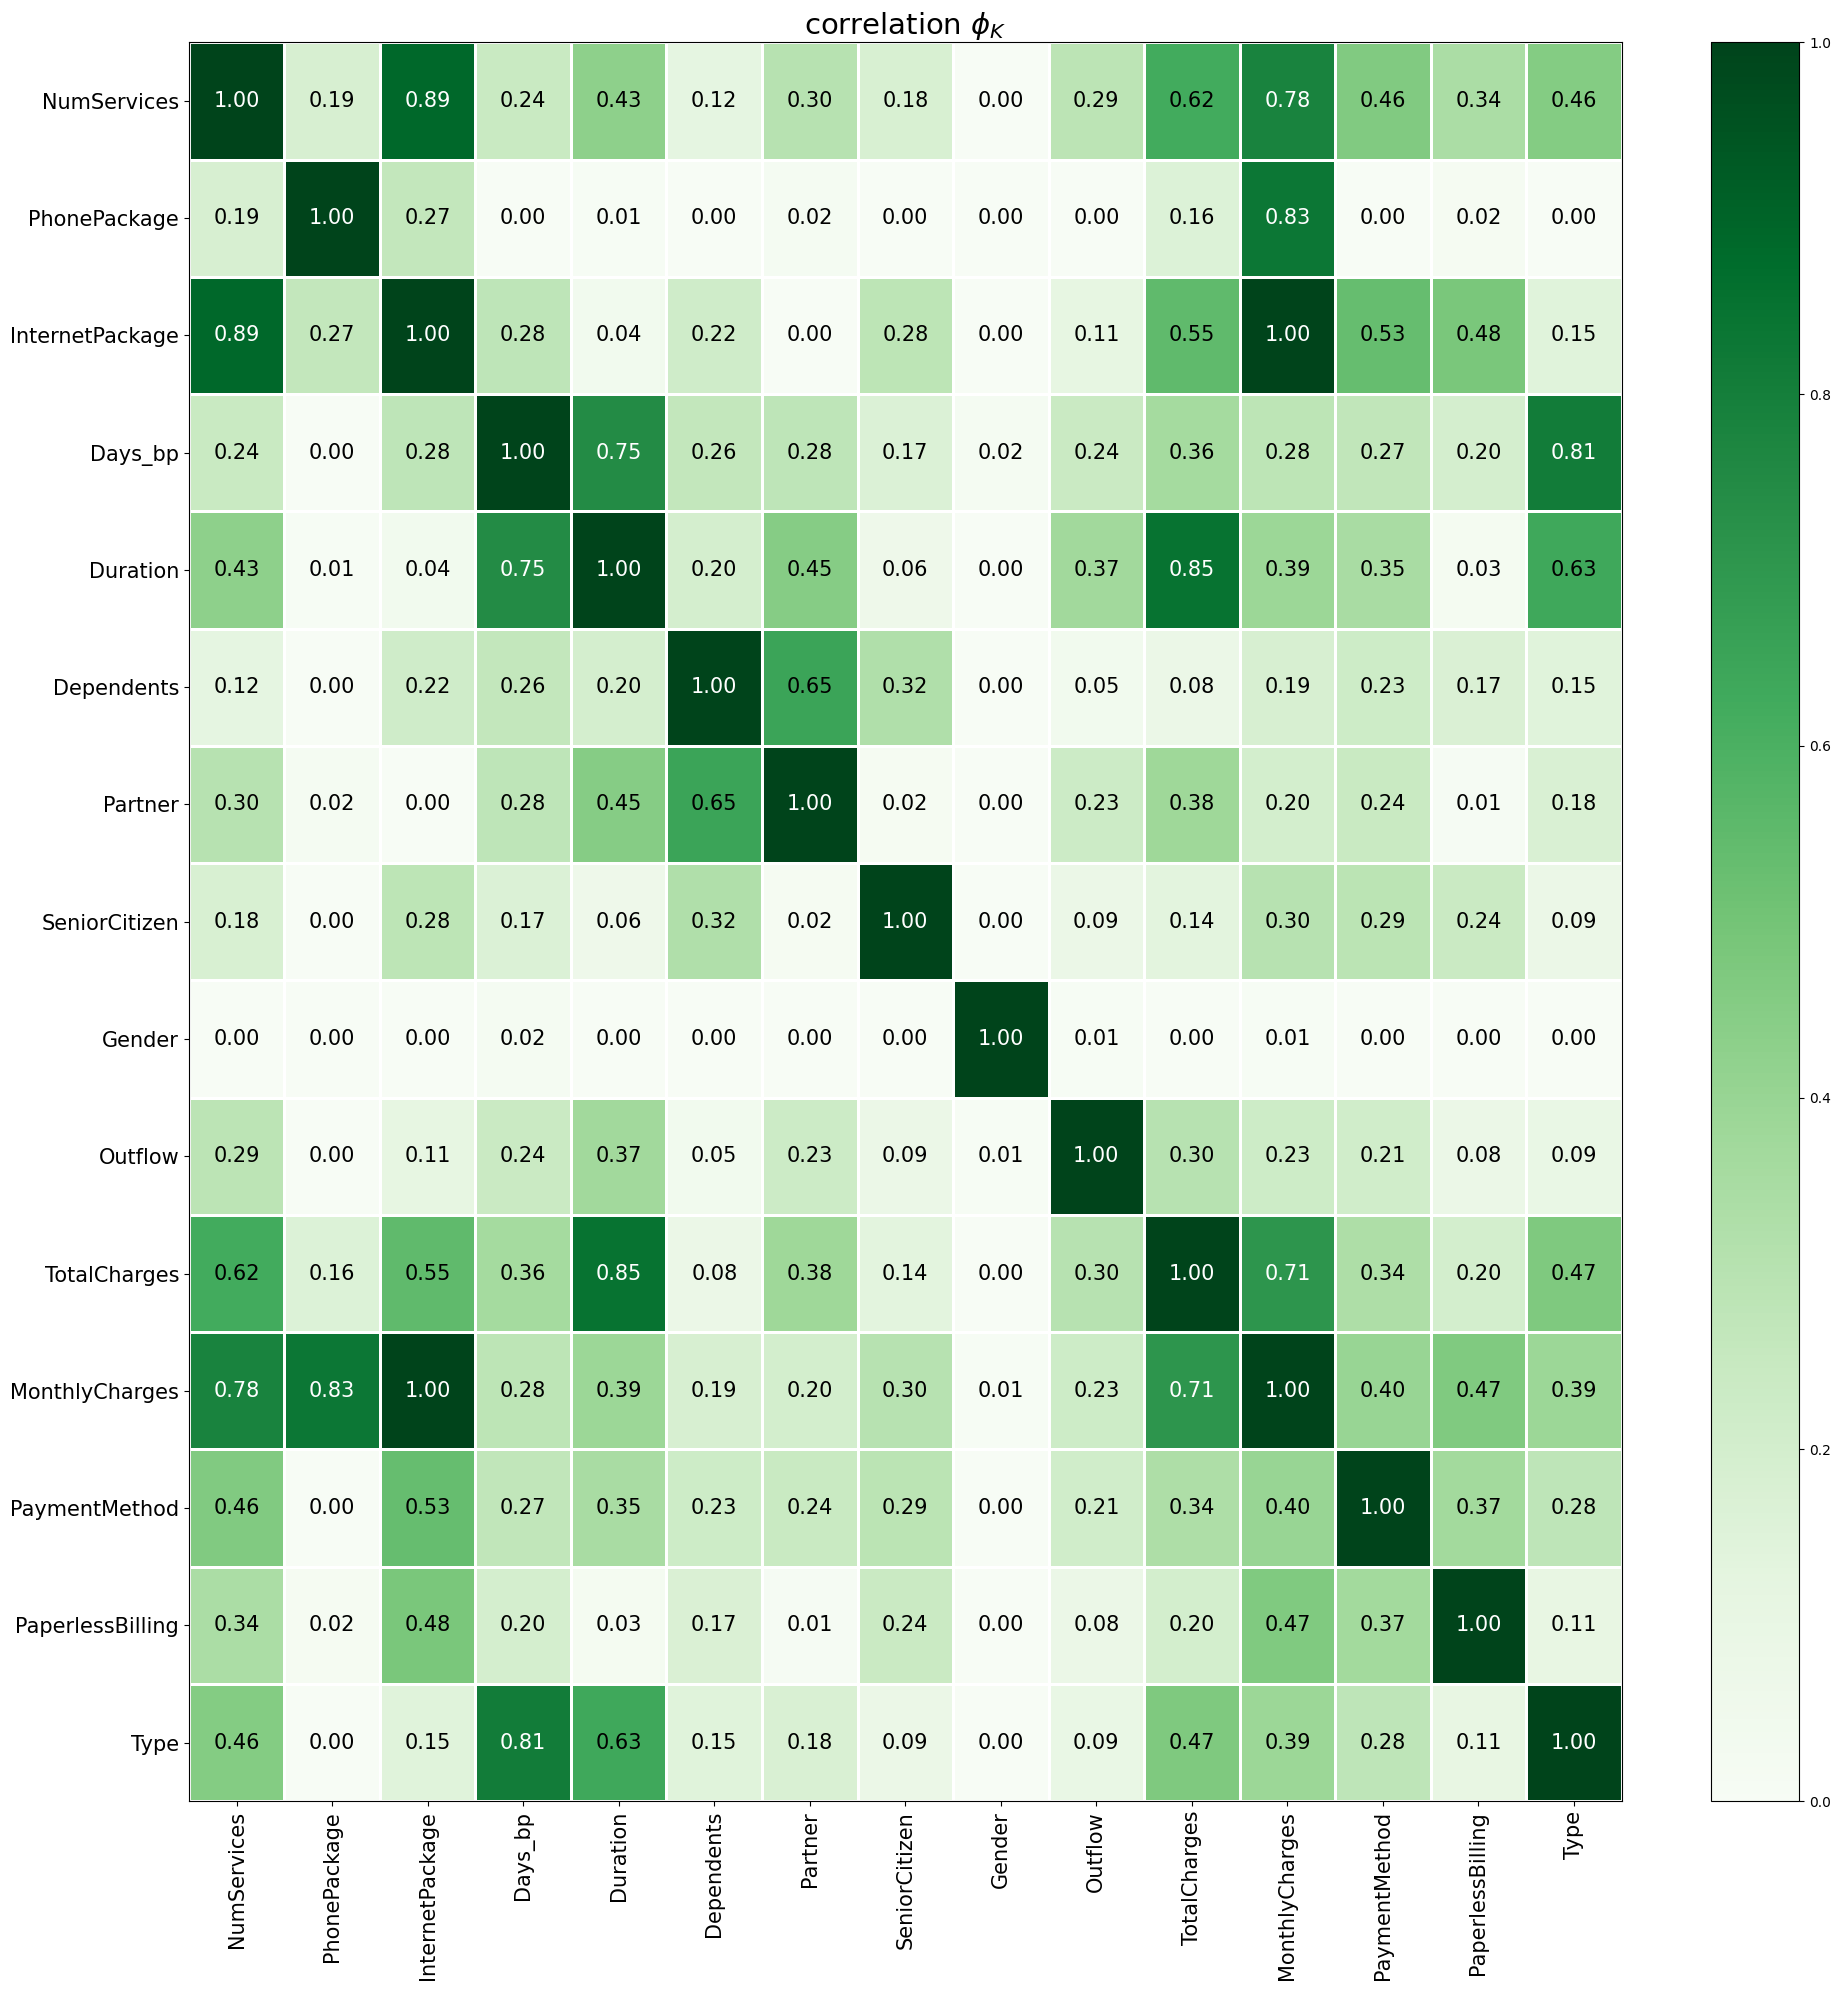

In [62]:
# Построим матрицу `phik`
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 20)
)

Как видно, столбец `'Gender'` явно лишний, так как он со всеми признаками имеет практически нулевую корреляцию. Его нужно удалить. С целевым признаком почти нет взаимосвязи у столбцов `'PhonePackage'`, `'Dependents'`, `'PaperlessBilling'`, `'Type'`, `'SeniorCitizen'`. Но эти столбцы оставим, возможно, они могут принести хоть какую-то пользу в нашем анализе.  
Имеются очень высокие коэффициенты корреляции `phik`, что указывают на наличие мультиколлинеарности.  
Если в дальнейшем мы собираемся использовать линейную модель машинного обучения, то с мультиколлинеарностью необходимо бороться.  
Применим коэффициент инфляции дисперсии `VIF` для измерения силы корреляции между признаками.

In [63]:
data_best = data_best.drop(['Gender'], axis=1)
data_best.columns

Index(['Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'Outflow', 'SeniorCitizen', 'Partner', 'Dependents',
       'Duration', 'Days_bp', 'InternetPackage', 'PhonePackage',
       'NumServices'],
      dtype='object')

In [64]:
# Составим расчётную матрицу для модели, используя `Outflow` в качестве таргета
y, X = dmatrices(
    'Outflow ~ Type+PaperlessBilling+PaymentMethod+MonthlyCharges+TotalCharges+\
    SeniorCitizen+Partner+Dependents+Duration+Days_bp+InternetPackage+PhonePackage+NumServices',
    data=data_best,
    return_type='dataframe'
)
# Вычислим VIF для каждой независимой переменной
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

# Выведем на экран значения VIF для каждой независимой переменной
vif

,VIF,variable
0,37.204251,Intercept
1,1.754939,Type[T.One year]
2,3.530332,Type[T.Two year]
3,1.198562,PaperlessBilling[T.Yes]
4,1.560546,PaymentMethod[T.Credit card (automatic)]
5,1.952526,PaymentMethod[T.Electronic check]
6,1.835460,PaymentMethod[T.Mailed check]
7,1.141589,SeniorCitizen[T.1]
8,1.433294,Partner[T.Yes]
9,1.380279,Dependents[T.Yes]


Значения `VIF` для признаков `'MonthlyCharges'`, `'TotalCharges'` и `'Duration'` очень велики, это указывает на потенциально сильную корреляцию между данными признаками с другими. То есть присутствует мультиколлинеарность.
Попробуем посчитать `VIF`, убрав признаки `'MonthlyCharges'` и `'TotalCharges'`.

In [65]:
y, X = dmatrices(
    'Outflow ~ Type+PaperlessBilling+PaymentMethod+SeniorCitizen+Partner+\
    Dependents+Duration+Days_bp+InternetPackage+PhonePackage+NumServices',
    data=data_best,
    return_type='dataframe'
)
# Вычислим VIF для каждой независимой переменной
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

# Выведем на экран значения VIF для каждой независимой переменной
vif

,VIF,variable
0,28.319211,Intercept
1,1.735560,Type[T.One year]
2,3.477418,Type[T.Two year]
3,1.171550,PaperlessBilling[T.Yes]
4,1.559607,PaymentMethod[T.Credit card (automatic)]
5,1.917108,PaymentMethod[T.Electronic check]
6,1.799556,PaymentMethod[T.Mailed check]
7,1.122611,SeniorCitizen[T.1]
8,1.432314,Partner[T.Yes]
9,1.375816,Dependents[T.Yes]


Теперь все значения VIF небольшие. Мультиколлинеарность исключена. Значит, действительно, при построении линейной модели признаки `'MonthlyCharges'` и `'TotalCharges'` брать не нужно. Создадим новый датафрейм для обучения линейной модели `data_lr` без этих двух столбцов.

In [66]:
data_lr = data_best.drop(['MonthlyCharges', 'TotalCharges'], axis=1)
data_lr.head()

,Type,PaperlessBilling,PaymentMethod,Outflow,SeniorCitizen,Partner,Dependents,Duration,Days_bp,InternetPackage,PhonePackage,NumServices
customerID,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,0,0,Yes,No,31,1,Yes,No,1
5575-GNVDE,One year,No,Mailed check,0,0,No,No,1036,306,Yes,Yes,2
3668-QPYBK,Month-to-month,Yes,Mailed check,0,0,No,No,123,3,Yes,Yes,2
7795-CFOCW,One year,No,Bank transfer (automatic),0,0,No,No,1371,276,Yes,No,3
9237-HQITU,Month-to-month,Yes,Electronic check,0,0,No,No,153,3,Yes,Yes,0


**Выводы по предобработке данных.**
1. Созданы два отдельных датафрейма: для обучения линейной модели и для обучения других моделей.
2. Избыточные признаки удалены, вместо этого созданы более информативные признаки.  
3. Кроме того, некоторые признаки (например, `'Gender'`) мало значимы для нашего исследования: влияние таких признаков на отток клиентов минимально.
4. Исключили признак абсолютно бесполезный: `'Gender'`.

## Подготовка данных

Перед нами стоит задача классификации.  
Целевая метрика нечувствительна к дисбалансу, поэтому балансировать классы мы не будем. При разделении на выборки укажем стратификацию по целевому признаку.  
Разные алгоритмы машинного обучения могут хорошо работать с данными с разной подготовкой, поэтому выполним для каждой модели свою предобработку данных.  
Для обучения используем три разные модели: `LogisticRegression`, `DecisionTreeClassifier`, `CatBoostClassifier`.  
Для модели `LogisticRegression` числовые признаки необхоимо масштабировать, категориальные - кодировать, лучше применить `OneHotEncoder`, так как уникальных значений признаков у нас мало, почти все они бинарные.  
Для модели `DecisionTreeClassifier` масштабирование числовых признаков не нужно, категориальные признаки нужно кодировать, лучше для этого использовать `OrdinalEncoder`, эта техника кодирует категориальные признаки так, что с ними удобнее работать древесным моделям в ходе создания разделяющих правил.
Бустинговая модель `CatBoostClassifier` будет лучше работать с использованием внутренних кодировщиков, поэтому ни масштабирование, ни кодирование применять не нужно, нужно лишь указать параметр `cat_features`.

In [67]:
# Обозначим типы исходных данных
# категориальные столбцы
cat_columns = ['Type',
               'PaperlessBilling',
               'PaymentMethod',
               'SeniorCitizen',
               'Partner',
               'Dependents',
               'InternetPackage',
               'PhonePackage']

# числовые столбцы
num_columns = ['MonthlyCharges',
               'TotalCharges', 
               'Duration',
               'Days_bp',
               'NumServices']

# числовые столбцы для линейной модели
num_columns_lr = ['Duration',
                  'Days_bp',
                  'NumServices']

### Подготовка данных для линейной модели

In [68]:
# Напишем функцию для подготовки и разделения данных
# функция принимает на вход датафрейм
def prepare_data(data):
    # переводим категориальные столбцы в тип `category`
    data[cat_columns] = data[cat_columns].astype('category')
    # разделение на входные и целевой признаки
    X = data.drop(['Outflow'], axis=1)
    y = data['Outflow']
    # разделение на тренировочную и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE,
        stratify=y
    )
    # контроль размера выборок
    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    
    # функция возвращает готовые выборки
    return X, y, X_train, X_test, y_train, y_test

In [69]:
# Подготовим данные для линейной модели
X_lr, y_lr, X_train_lr, X_test_lr, y_train_lr, y_test_lr = prepare_data(data_lr)

(5279, 11) (1760, 11) (5279,) (1760,)


In [70]:
# Добавляем OHE-кодирование в пайплайн для линейной модели
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe',
            OneHotEncoder(drop='first', handle_unknown='ignore')
        )      
    ]
)

# Объединяем операции по подготовке данных
data_preprocessor_lr = ColumnTransformer(
    [
        ('ohe', ohe_pipe, cat_columns),
        ('num', StandardScaler(), num_columns_lr)
    ],
    remainder='passthrough'
)

data_preprocessor_lr

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe',
                                 Pipeline(steps=[('simpleImputer_ohe',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['Type', 'PaperlessBilling', 'PaymentMethod',
                                  'SeniorCitizen', 'Partner', 'Dependents',
                                  'InternetPackage', 'PhonePackage']),
                                ('num', StandardScaler(),
                                 ['Duration', 'Days_bp', 'NumServices'])])

### Подготовка данных для нелинейных моделей

In [71]:
X, y, X_train, X_test, y_train, y_test = prepare_data(data_best)

(5279, 13) (1760, 13) (5279,) (1760,)


In [72]:
# Добавляем Ordinal-кодирование в пайплайн для подготовки древесной модели
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

# Объединяем операции по подготовке данных
data_preprocessor = ColumnTransformer(
    [
        ('ord', ord_pipe, cat_columns)
    ],
    remainder='passthrough'
)

data_preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('ord',
                                 Pipeline(steps=[('simpleImputer_before_ord',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ord',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=nan)),
                                                 ('simpleImputer_after_ord',
                                                  SimpleImputer(strategy='most_frequent'))]),
                                 ['Type', 'PaperlessBilling', 'PaymentMethod',
                                  'SeniorCitizen', 'Partner', 'Dependents',
                                  'InternetPackage', 'PhonePackage'])])

**Вывод по подготовке данных**  
1. Выделены категориальные и численные столбцы, данные категориальных столбцов переведеды в нужный тип.  
2. Выборки разделены на входные и целевой признаки, на тренировочную и тестовую выборки.  
3. Созданы пайплайны для подготовки данных для линейной модели и для дерева решений.
4. Бустинговая модель подготовки данных не требует.

## Обучение моделей

### Модель логистической регрессии

In [73]:
# Создаём итоговый пайплайн для линейной модели, присоединяем шаг с моделированием
pipe_final_lr = Pipeline(
    [
        ('preprocessor', data_preprocessor_lr),
        ('models', LogisticRegression(random_state=RANDOM_STATE))
    ]
)

pipe_final_lr

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Type', 'PaperlessBilling',
                                                   'PaymentMethod',
                                                   'SeniorCitizen', 'Partner',
                                                   'Dependents',
                                                   'InternetPackage',
                                                   'PhonePackage']),
                                                 ('num', StandardScaler(),
                                                  ['Duration', 'Days_bp',
                                                   'NumServices'])])),
                ('models', LogisticRegression(random_state=50824))])

In [74]:
# Подбираем гиперпараметры
param_distributions_lr = [
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'models__C': np.linspace(1, 5, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [75]:
# Перебираем варианты гиперпараметров
randomized_search_lr = RandomizedSearchCV(
    pipe_final_lr, 
    param_distributions=param_distributions_lr, 
    scoring='roc_auc', 
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [76]:
%%time
# Запускаем перебор на тренировочной выборке
randomized_search_lr.fit(X_train_lr, y_train_lr)

CPU times: total: 391 ms
Wall time: 1.37 s


RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore'))]),
                                                                               ['Type',
                                                                                'PaperlessBilling',
                                                                                'PaymentMethod',
                                                                                'SeniorCitizen',
                                                                                'Partner',
                                                                                'Dependents',
                                                                                'Int...
                                             ('models',
                                              LogisticRegression(random_state=50824))]),
                   n_jobs=-1,
                   param_distributions=[{'models': [LogisticRegression(random_state=50824)],
                                         'models__C': array([1.        , 1.44444444, 1.88888889, 2.33333333, 2.77777778,
       3.22222222, 3.66666667, 4.11111111, 4.55555556, 5.        ]),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=50824, scoring='roc_auc')

In [77]:
print('Метрика ROC_AUC на кросс-валидации: ', round(randomized_search_lr.best_score_, 3))
print('Лучшая модель и её параметры:\n\n', randomized_search_lr.best_estimator_)
print('Гиперпараметры модели: ', randomized_search_lr.best_params_)

Метрика ROC_AUC на кросс-валидации:  0.737
Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Type', 'PaperlessBilling',
                                                   'PaymentMethod',
                                                   'SeniorCitizen', 'Partner',
                                                   'Dependents',
        

Перебор гиперпараметров прошёл очень быстро, за 3.79 секунды. Модель логистической регрессии с масштабированием `MinMaxScaler`, с параметром регуляризации `C=1.444` показала значение метрики `ROC-AUC=0.737`.

### Модель дерева решений

In [78]:
# Создаём итоговый пайплайн, используем модель DecisionTreeClassifier
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

pipe_final

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['Type', 'PaperlessBilling',
                                                   'PaymentMethod',
                                                   'SeniorCitizen', 'Partner',
                                                   'Dependents',
                                                   'InternetPackage',
                                                   'PhonePackage'])])),
                ('models', DecisionTreeClassifier(random_state=50824))])

In [79]:
# Подбираем гиперпараметры для дерева решений
param_distributions_dtc = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__min_samples_split': range(2, 11),
        'models__min_samples_leaf': range(2, 11),
        'models__max_leaf_nodes': range(100, 200),
        'models__max_depth': [None] + [i for i in range(2, 7)]
    }
]

In [80]:
# Перебираем варианты гиперпараметров
randomized_search_dtc = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_distributions_dtc, 
    scoring='roc_auc', 
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [81]:
%%time
# Запускаем перебор на тренировочной выборке
randomized_search_dtc.fit(X_train, y_train)

CPU times: total: 250 ms
Wall time: 851 ms


RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ord',
                                                                               Pipeline(steps=[('simpleImputer_before_ord',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ord',
                                                                                                OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                               unknown_value=nan)),
                                                                                               ('simpleImputer_after_ord',
                                                                                                SimpleImputer(strategy='most_frequent...
                                                                                'PhonePackage'])])),
                                             ('models',
                                              DecisionTreeClassifier(random_state=50824))]),
                   n_jobs=-1,
                   param_distributions=[{'models': [DecisionTreeClassifier(random_state=50824)],
                                         'models__max_depth': [None, 2, 3, 4, 5,
                                                               6],
                                         'models__max_leaf_nodes': range(100, 200),
                                         'models__min_samples_leaf': range(2, 11),
                                         'models__min_samples_split': range(2, 11)}],
                   random_state=50824, scoring='roc_auc')

In [82]:
print('Метрика ROC_AUC на кросс-валидации:', round(randomized_search_dtc.best_score_, 3))
print('Лучшая модель и её параметры:\n\n', randomized_search_dtc.best_estimator_)
print('Гиперпараметры лучшей модели: ', randomized_search_dtc.best_params_)

Метрика ROC_AUC на кросс-валидации: 0.796
Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['Type', 'PaperlessBil

Перебор гиперпараметров прошёл быстро, за 742 миллисекунды. Модель дерева решений с параметрами `min_samples_split=9`, `min_samples_leaf=8`, `max_leaf_nodes=1`, `max_depth=6` показала значение метрики `ROC-AUC=0.796`.

### Бустинговая модель

In [83]:
# Бустинговая модель без пайплайна подготовки данных
model_cbc = CatBoostClassifier(cat_features=cat_columns, random_state=RANDOM_STATE, verbose=50)
params_cbc = {
    'depth': range(2, 5),
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': range(200, 300, 50)
}

In [84]:
# Перебираем варианты гиперпараметров
randomized_search_cbc = RandomizedSearchCV(
    model_cbc, 
    param_distributions=params_cbc, 
    scoring='roc_auc', 
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [85]:
%%time
# Запускаем перебор на тренировочной выборке
randomized_search_cbc.fit(X_train, y_train)

0:	learn: 0.6211594	total: 175ms	remaining: 43.5s
50:	learn: 0.3226301	total: 715ms	remaining: 2.79s
100:	learn: 0.3052645	total: 1.28s	remaining: 1.88s
150:	learn: 0.2788064	total: 1.85s	remaining: 1.22s
200:	learn: 0.2561697	total: 2.44s	remaining: 595ms
249:	learn: 0.2448762	total: 3.01s	remaining: 0us
CPU times: total: 3.05 s
Wall time: 48.2 s


RandomizedSearchCV(estimator=<catboost.core.CatBoostClassifier object at 0x000002122628F610>,
                   n_jobs=-1,
                   param_distributions={'depth': range(2, 5),
                                        'iterations': range(200, 300, 50),
                                        'learning_rate': [0.01, 0.05, 0.1]},
                   random_state=50824, scoring='roc_auc')

In [86]:
print('Метрика ROC_AUC на кросс-валидации:', round(randomized_search_cbc.best_score_, 3))
print('Лучшая модель и её параметры:\n\n', randomized_search_cbc.best_estimator_)
print('Гиперпараметры лучшей модели: ', randomized_search_cbc.best_params_)

Метрика ROC_AUC на кросс-валидации: 0.887
Лучшая модель и её параметры:

Гиперпараметры лучшей модели:  {'learning_rate': 0.1, 'iterations': 250, 'depth': 3}


Перебор гиперпараметров прошёл за 40,8 секунды. Бустинговая модель с параметрами `learning_rate=0.1`, `iterations=250`, `depth=3` показала значение метрики `ROC-AUC=0.887`.

## Выбор лучшей модели

In [87]:
# Составим таблицу по результатам обучения трёх разных моделей
results = pd.DataFrame({'Model_name': ['LinearRegression', 'DecisionTreeClassifier', 'CatBoostClassifier'],
                        'Model': [
                            randomized_search_lr.best_estimator_,
                            randomized_search_dtc.best_estimator_,
                            randomized_search_cbc.best_estimator_],
                        'Params': [
                            randomized_search_lr.best_params_,
                            randomized_search_dtc.best_params_,
                            randomized_search_cbc.best_params_],
                        'ROC_AUC': [
                            round(randomized_search_lr.best_score_, 3), 
                            round(randomized_search_dtc.best_score_, 3),
                            round(randomized_search_cbc.best_score_, 3)],
                        })
results = results.sort_values(by='ROC_AUC', ascending=False)
results

,Model_name,Model,Params,ROC_AUC
2,CatBoostClassifier,<catboost.core.CatBoostClassifier object at 0x...,"{'learning_rate': 0.1, 'iterations': 250, 'dep...",0.887
1,DecisionTreeClassifier,"(ColumnTransformer(remainder='passthrough',\n ...","{'models__min_samples_split': 9, 'models__min_...",0.796
0,LinearRegression,"(ColumnTransformer(remainder='passthrough',\n ...","{'preprocessor__num': MinMaxScaler(), 'models_...",0.737


In [88]:
print('Лучшая модель: ', results.iloc[0]['Model_name'])
print('Гиперпараметры лучшей модели: ', results.iloc[0]['Params'])
print('Метрика ROC-AUC лучшей модели: ', results.iloc[0]['ROC_AUC'])

Лучшая модель:  CatBoostClassifier
Гиперпараметры лучшей модели:  {'learning_rate': 0.1, 'iterations': 250, 'depth': 3}
Метрика ROC-AUC лучшей модели:  0.887


In [89]:
# Предсказания значений для X_test для лучшей модели
best_estimator = results.iloc[0]['Model']
pred_cbc_test = best_estimator.predict_proba(X_test)[:, 1]

# Считаем метрику `AUC-ROC` для лучшей модели
roc_auc_test = round(roc_auc_score(y_test, pred_cbc_test), 3)

# Выводим значения метрик `AUC-ROC` на тренировочных и на тестовых данных
print('Метрика ROC-AUC лучшей модели на тренировочных данных: ', results.iloc[0]['ROC_AUC'])
print('Метрика ROC-AUC лучшей модели на тестовых данных: ', roc_auc_test)

Метрика ROC-AUC лучшей модели на тренировочных данных:  0.887
Метрика ROC-AUC лучшей модели на тестовых данных:  0.884


Итак, метрика `ROC-AUC` на тренировочных данных составила 0.887, на тестовых данных - 0.884. Это удовлетворяет условиям заказчика.  

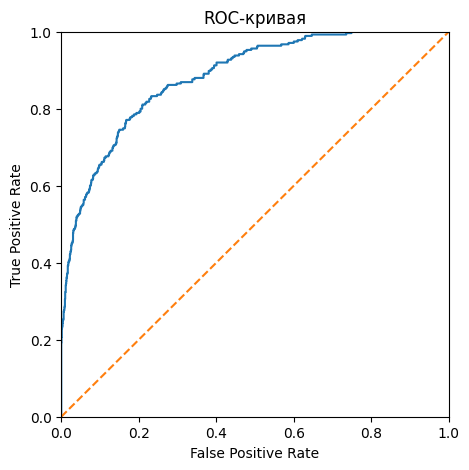

In [90]:
# Построим график ROC-кривой
fpr, tpr, threshold = roc_curve(y_test, pred_cbc_test)
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show();

Как видно на графике, ROC-кривая очень сильно отклоняется от прямой, это означает, что наша работа имеет хороший результат.

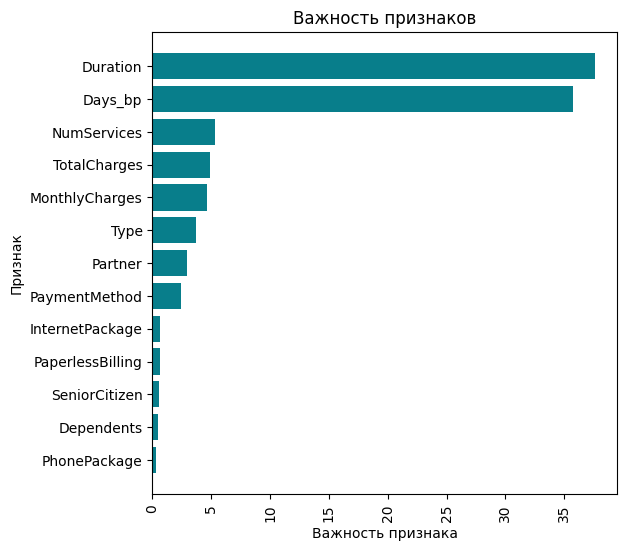

In [91]:
# Проведем анализ важности признаков выбранной модели
importances = pd.DataFrame(data={'Attribute': X.columns,'Importance': best_estimator.feature_importances_})
importances = importances.sort_values(by='Importance', ascending=True)
plt.figure(figsize=(6, 6))
plt.barh(y=importances['Attribute'], width=importances['Importance'], color='#087E8B')
plt.title('Важность признаков', size=12)
plt.xticks(rotation='vertical')
plt.xlabel('Важность признака', fontsize=10)
plt.ylabel('Признак', fontsize=10)
plt.show();

График важности признаков позволяет сделать следующие выводы:
- сильнее всего на целевой показатель оттока клиентов влияет признак `'Duration'` - длительность договора в днях, созданный нами на основе данных о дате начала и окончания контракта, его важность в несколько раз превышает важность большинства других признаков;
- почти настолько же важен признак `'Days_bp'` - число дней до очередного платежа, он также в несколько раз отличается по важности от других признаков;
- следующая группа влиятельных признаков: `'TotalCharges'` - общие расходы абонента, `'NumServices'` - число дополнительных услуг (созданный нами на основе данных о наличии разных услуг у абонента), `'Type'` - тип оплаты, `'MonthlyCharges'` - расходы за месяц;
- некоторое влияние на целевой показатель оказывают также `'Partner'` - наличие супруга или супруги у абонента, `'PaymentMethod'` - тип платежа;
- остальные признаки почти не оказывают влияния на целевой показатель, это `'SeniorCitizen'` - наличие статуса пенсионера, `'Paperlessbilling'` - электронный расчётный лист, `'Dependents'` - наличие детей у абонента, `'InternetPackage'` - наличие пакета интернет-услуг, `'PhonePackage'` - наличие пакета телефонных услуг.

Итак, созданные нами признаки оказались лучшими.

In [92]:
# Проводим оценку точности модели для заказчика
# предсказания лучшей модели
y_pred = best_estimator.predict(X_test)

# метрики accuracy, recall, precision
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print('accuracy: ', round(accuracy, 3))
print('recall: ', round(recall, 3))
print('precision: ', round(precision, 3))

accuracy:  0.89
recall:  0.385
precision:  0.809


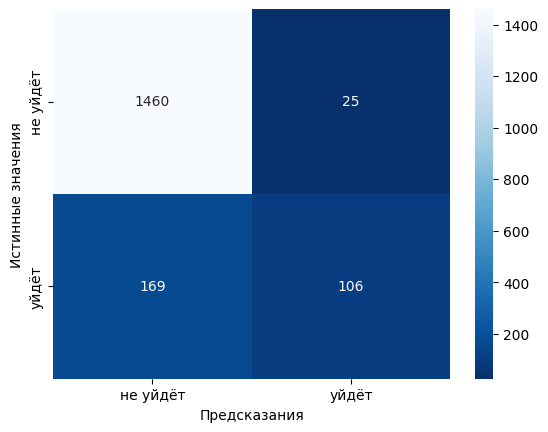

In [93]:
# Построим матрицу ошибок
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm,
            annot=True, 
            fmt='d', 
            cmap='Blues_r', 
            xticklabels=['не уйдёт', 'уйдёт'],
            yticklabels=['не уйдёт', 'уйдёт'])
plt.xlabel('Предсказания')
plt.ylabel('Истинные значения')
plt.show()

Матрица ошибок показывает, что отток клиента абсолютно верно модель предсказала в 106 случаях, то, что клиент останется - в 1460 случаях. Ошибку первого рода (ошибочно предсказывает уход) модель совершила 25 раз. Ошибку второго рода (классифицировала уходящего клиента как остающегося) модель совершила 169 раз.  
В нашем случае желательно избегать ошибок второго рода, и по запросу клиента можно минимизировать такую ошибку.  

Судя по метрике accuracy, точность модели 89 %, то есть модель предсказывает верно в 89 % случаев. Причём, где она ошибается, эта метрика не показывает. С одной стороны, она может предсказать, что клиент не уйдёт, а клиент уйдёт, и тогда компания потеряет клиента и не успеет вовремя предпринять попытку его удержать. С другой стороны, она может предсказать уход клиента, который не собирался уходить, и тогда компания будет предлагать промокоды и другие акции, потратив деньги по сути зря, то есть потерпит убытки. Риски во второй ситуации есть, но утрата клиента более критична для компании.  
Метрика `precision` показывает, что из всех предсказанных уходов верными оказались 80,9 % (ошибка первого рода).  
Метрика `recall` показывает, что из всех ушедших модель смогла правильно распознать как уходящих 38,5 % (ошибка второго рода).  
Для заказчика критичнее как раз ошибка 2-го рода, при которой клиент уходит, а компания об этом заранее не знала. Необходимо минимизировать ошибки 2-го рода, поэтому важнее, чтобы метрика `recall` имела высокое значение.  
В этом поможет регулирование порога для определения метки классов. По требованию заказчика можно рассчитать порог, чтобы минимизировать ошибки 2-го рода при прогнозе оттока клиентов. На данный момент такой задачи не поставлено.

## Общий вывод и рекомендации заказчику

Перед нами ставилась задача построить модель, которая будет предсказывать, расторгнет ли абонент договор с компанией, с целью повышения лояльности клиентов, планирующих расторгнуть договор.  

В ходе выполнения поставленной задачи были сделаны следующие шаги:  

1. Загружены данные и выполнен их исследовательский анализ, в ходе которого данные проверены, исправлены, объединены, аномалий не выявлено, пропуски и дубликаты обработаны.
2. Целевой признак имеет дисбаланс, однако целевая метрика `ROC-AUC` не чувствительна к дисбалансу классов, и нами принято решение не бороться с дисбалансом, а для некоторых моделей можно лишь указать на него.
3. Исследование входных признаков обнаружило, что некоторые ризнаки не влияют на целевой показатель. Нами созданы новые признаки на основе малоинформативных признаков, а слабые признаки удалены. Удалены также признаки, способные вызвать утечку данных.  
   Признак самый слабый, удалённый при исследовательском анализе: `Gender` - пол абонента.  
   Признаки, которые нами созданы:  
   - `'Duration'` - длительность договора, создан на основе признаков `'BeginDate'` и `'EndDate'`;
   - `'Days_bp'` - число дней до очередного платежа, создан на основе признака `'Type'`;
   - `'InternetPackage'` - наличие пакета интернет-услуг, создан на основе признака `'InternetService'`;
   - `'PhonePackage'` - наличие пакета телефонных услуг, создан на основе признака `'MultipleLines'`;
   - `'NumServices'` - количество дополнительных услуг, создан на основе нескольких признаков с отдельными услугами.
    Признаки, которые нами удалены как способные вызвать утечку данных:
    - `'BeginDate'` - дата начала действия договора;
    - `'EndDate'` - дата окончания действия договора;
    - `'InternetServise'` - тип подключения;
    - `'OnlineSecurity'` - блокировка опасных сайтов;
    - `'OnlineBackup'` - облачное хранилище файлов для резервного копирования данных;
    - `'DeviceProtection'` - антивирус;
    - `'TechSupport'` - выделенная линия технической поддержки;
    - `'StreamingTV'` - стриминговое телевидение;
    - `'StreamingMovies'` - каталог фильмов;
    - `'MultipleLines'` - подключение телефона к нескольким линиям одновременно.
5. Данные разделены на тренировочные и тестовые выборки, при разделении указана стратификация по целевому признаку. Выполнена подготовка данных отдельная для каждой модели.
6. Обучены 3 модели: `LogisticRegression`, `DecisionTreeClassifier`, `CatBoostClassifier`.
7. Лучший результат показала модель `CatBoostClassifier` с гиперпараметрами `learning_rate=0.1`, `iterations=250`, `depth=3`. Значение метрики `ROC-AUC` на тренировочной выборке 0.887, на тестовой выборке 0.883.
8. Дополнительно рассчитана метрика `Accuracy`, её значение 0.89, то есть доля верных предсказаний составила 89 %.
9. Матрица ошибок и метрики `Recall` и `Precision` показали, что модель чаще допускает ошибки 2-го рода, из всех ушедших модель смогла правильно распознать как уходящих 38,5 %. Но из всех предсказанных уходов верными оказались 80,9 %.  Задачи минимизировать ошибки конкретного рода перед нами не стояло, в целом модель достаточно точна.
10. Для улучшения результатов предсказаний моделью и дальнейшей её настройки рекомендуется продолжить сбор данных, чтобы увеличить объём и повысить актуальность исходных данных.

Итак, используя созданную и проверенную модель, показывающую достаточно точные результаты, компания `"ТелеДом"` может выявлять клиентов, планирующих разорвать договор, и своевременно сделать им предложения, повысив тем самым их лояльность компании и стимулируя изменить своё решение об уходе.  

Рекомендации по снижению уровня оттока следующие:  
1) Клиентам, оплачивающим годовой или двухгодовой абонемент, предложить более выгодные условия, так как именно у этих клиентов уровень оттока выше.  
2) Обратить внимание на клиентов, подключивших автоплатежи, предложить им кэшбэк или другие бонусы, так как именно у этих клиентов уровень оттока выше.  
3) Предложить специальные условия для супруга(супруги) абонента или просто сделать акцию "приведи друга", так как уровень оттока выше у имеющих партнёра.  
4) Предложить детям абонента что-то интересное (имеющим услугу телевидения - мультфильмы, имеющим телефонную связь - рингтоны и т.д.), так как уровень оттока выше у имеющих детей.
5) Обратить внимание на тип подключения "Волоконно-оптическая линия", выяснить, надлежащее ли качество подключения, и улучшить соотношение цена-качество, так как уровень оттока клиентов выше именно на типе подключения "ВОЛС".  
6) Проверить абсолютно все подключаемые услуги, их качество и уровень цен, так как уровень оттока выше именно у клиентов, имеющих от 3 до 7 дополнительно подключённых услуг.
7) Сделать специальные предложения клиентам, имеющим длительность договора от 2,5 лет, "награда за стаж", так как именно на этом сроке убывает самое большое количество клиентов.
8) Чаще всего у клиентов остаётся 1-2 дня до следующего платежа, когда они уходят. Можно высылать напоминание и дополнительно при этом информацию о новинках, предстоящих акциях и улучшениях, вводимых в компании.